In [1]:
import os
import sys
from multiprocessing import Pool

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import END_OF_POST_TOKEN, PATH_INTERIM_CORPUS  # noqa: E402
from src.features.build_features import get_corpus_id2word  # noqa: E402

In [2]:
CORPUS_KIND = "reddit"
CORPUS_NAME = "gambling"
NUM_SUB_PROCESSES = int(2 * os.cpu_count() / 3)

## Generate a DataFrame for the training and testing datasets

In [3]:
input_file_path_train = os.path.join(
    PATH_INTERIM_CORPUS, CORPUS_KIND, CORPUS_NAME, f"{CORPUS_NAME}-train-clean.txt"
)
input_file_path_test = os.path.join(
    PATH_INTERIM_CORPUS, CORPUS_KIND, CORPUS_NAME, f"{CORPUS_NAME}-test-clean.txt"
)

In [4]:
labels = []
documents = []
with open(input_file_path_train) as f:
    for line in f:
        label, document = line.split(maxsplit=1)
        labels.append(label)
        posts = document.split(END_OF_POST_TOKEN)
        documents.append(posts)
df_train = pd.DataFrame({"label": labels, "posts": documents})

In [5]:
labels = []
documents = []
with open(input_file_path_test) as f:
    for line in f:
        label, document = line.split(maxsplit=1)
        labels.append(label)
        posts = document.split(END_OF_POST_TOKEN)
        documents.append(posts)
df_test = pd.DataFrame({"label": labels, "posts": documents})

## Define functions to obtain interesting features from the documents

In [6]:
TextBlob(df_test.posts[0][0]).sentiment

Sentiment(polarity=0.2, subjectivity=0.3)

In [7]:
def get_num_tokens(posts_list):
    return [len(post.split()) for post in posts_list]


def get_num_tokens_first_person(posts_list):
    return [
        sum(1 if word == "i" else 0 for word in post.split()) for post in posts_list
    ]


def get_polarity(posts_list):
    return [round(TextBlob(post).sentiment.polarity, 2) for post in posts_list]


def get_subjectivity(posts_list):
    return [round(TextBlob(post).sentiment.subjectivity, 2) for post in posts_list]

## Apply functions to the training corpus

In [8]:
df_train["num_tokens"] = df_train.posts.apply(get_num_tokens)
df_train["num_tokens_first_person"] = df_train.posts.apply(get_num_tokens_first_person)
df_train["polarity"] = df_train.posts.apply(get_polarity)
df_train["subjectivity"] = df_train.posts.apply(get_subjectivity)

In [9]:
df_train

label                                              posts  \
0    negative  [for one single frame of captain carter what i...   
1    positive  [congratz, lets gooo my friend every second co...   
2    negative  [but it's been said right wing news reporting ...   
3    negative  [standing up to government officials and judge...   
4    negative  [zombie finger attack, where i looked before i...   
..        ...                                                ...   
742  negative  [stand back and stand by, history is repeating...   
743  negative  [i hope you're doing more than just being ener...   
744  negative  [each one of those flights far outpaces the co...   
745  negative  [let me see using one of your siblings to simu...   
746  positive  [tips how do you know if you got a tip also wh...   

                                            num_tokens  \
0    [18, 1, 1, 2, 8, 5, 11, 9, 8, 8, 5, 10, 8, 2, ...   
1    [1, 25, 20, 2, 11, 4, 3, 1, 1, 67, 38, 80, 1, ...   
2    [160, 5, 123, 12, 21, 103, 33, 15, 37, 22, 25,...   
3    [48, 36, 12, 6, 8, 16, 6, 22, 13, 44, 5, 50, 2...   
4    [3, 11, 9, 17, 52, 195, 21, 3, 24, 14, 2, 25, ...   
..                                                 ...   
742  [5, 34, 3, 8, 12, 40, 184, 115, 59, 96, 67, 83...   
743  [193, 26, 215, 12, 84, 102, 19, 16, 19, 23, 23...   
744  [43, 7, 13, 65, 4, 38, 28, 28, 6, 16, 11, 56, ...   
745  [33, 14, 31, 9, 4, 20, 14, 49, 47, 13, 72, 10,...   
746  [20, 2, 93, 108, 25, 19, 2, 38, 59, 48, 28, 19...   

                               num_tokens_first_person  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 5, 0, 0, 5, ...   
2    [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 3, ...   
3    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
4    [0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 3, 0, 0, 0, ...   
..                                                 ...   
742  [0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, ...   
743  [3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...   
744  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
745  [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...   
746  [0, 0, 7, 9, 1, 0, 0, 0, 2, 0, 1, 0, 0, 2, 6, ...   

                                              polarity  \
0    [-0.54, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.37, ...   
1    [0.0, 0.17, 0.12, 0.0, 0.17, 0.35, 0.0, 0.0, -...   
2    [0.09, 0.0, -0.07, 0.0, 0.16, 0.06, 0.8, -0.05...   
3    [0.47, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5, -0.2, -0....   
4    [0.0, 0.0, 0.29, -0.0, 0.25, 0.09, 0.0, 1.0, 0...   
..                                                 ...   
742  [0.0, 0.17, 0.0, 0.0, 0.0, 0.19, -0.05, 0.16, ...   
743  [0.24, 0.0, 0.05, 0.12, 0.09, 0.19, 0.5, 0.05,...   
744  [0.17, 0.35, 0.0, -0.16, 0.4, -0.06, -0.2, -0....   
745  [-0.17, 0.0, 1.0, 0.0, 0.0, -0.16, 0.0, 0.2, 0...   
746  [0.0, 0.0, -0.15, 0.05, 0.0, 0.2, 0.0, -0.03, ...   

                                          subjectivity  
0    [0.61, 0.0, 0.0, 0.0, 0.0, 1.0, 0.52, 0.7, 0.5...  
1    [0.0, 0.17, 0.39, 0.0, 0.62, 0.65, 0.0, 0.0, 0...  
2    [0.41, 0.0, 0.38, 0.0, 0.37, 0.34, 0.75, 0.05,...  
3    [0.79, 0.0, 1.0, 0.0, 0.0, 1.0, 0.5, 0.7, 0.2,...  
4    [0.0, 0.0, 0.54, 0.54, 0.85, 0.31, 0.0, 1.0, 0...  
..                                                 ...  
742  [0.0, 0.28, 0.0, 0.0, 0.0, 0.5, 0.56, 0.47, 0....  
743  [0.52, 0.0, 0.42, 0.67, 0.39, 0.57, 0.5, 1.0, ...  
744  [0.85, 0.35, 0.0, 0.45, 0.4, 0.75, 0.0, 0.0, 0...  
745  [0.17, 0.0, 1.0, 0.0, 0.0, 0.34, 0.0, 0.9, 0.0...  
746  [0.0, 0.0, 0.57, 0.1, 0.0, 0.65, 0.0, 0.44, 0....  

[747 rows x 6 columns]

## Apply functions to the testing corpus

In [10]:
df_test["num_tokens"] = df_test.posts.apply(get_num_tokens)
df_test["num_tokens_first_person"] = df_test.posts.apply(get_num_tokens_first_person)
df_test["polarity"] = df_test.posts.apply(get_polarity)
df_test["subjectivity"] = df_test.posts.apply(get_subjectivity)

In [11]:
df_test

label                                              posts  \
0    positive  [commenting because i was looking for this pos...   
1    positive  [newb searching for answers i went to withdraw...   
2    positive  [day number need this to be over, day number m...   
3    negative  [creating game thumbnails and gamepass thumbna...   
4    negative  [no it isn't i believe there are around number...   
..        ...                                                ...   
743  negative  [the one thing they needed to the massive tax ...   
744  negative  [did no one see the montage that was getting t...   
745  negative  [we'd all be relieved, nah the knockout game i...   
746  negative  [part number this guys quality of production i...   
747  negative  [it's a shorthand knock on the world peace and...   

                                            num_tokens  \
0    [14, 21, 63, 5, 601, 120, 133, 55, 8, 21, 3, 5...   
1    [78, 53, 854, 85, 65, 4, 5, 57, 101, 250, 37, ...   
2    [7, 41, 77, 42, 2, 31, 378, 8, 5, 3, 7, 5, 113...   
3    [13, 9, 114, 8, 7, 10, 5, 45, 4, 12, 6, 56, 10...   
4    [52, 28, 18, 56, 179, 7, 25, 15, 59, 61, 391, ...   
..                                                 ...   
743  [14, 17, 22, 3, 30, 37, 13, 11, 36, 60, 4, 26,...   
744  [23, 47, 125, 126, 55, 38, 22, 51, 8, 43, 49, ...   
745  [4, 25, 11, 30, 22, 6, 95, 11, 22, 44, 8, 31, ...   
746  [9, 29, 3, 4, 29, 153, 12, 6, 2, 35, 11, 207, ...   
747  [89, 40, 41, 16, 7, 30, 15, 29, 182, 21, 96, 1...   

                               num_tokens_first_person  \
0    [1, 0, 1, 0, 29, 7, 7, 2, 0, 0, 0, 0, 7, 1, 2,...   
1    [4, 4, 43, 4, 3, 0, 0, 3, 8, 17, 2, 0, 6, 0, 1...   
2    [0, 0, 5, 0, 0, 1, 18, 1, 1, 0, 1, 1, 2, 1, 1,...   
3    [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, ...   
4    [2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, ...   
..                                                 ...   
743  [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, ...   
744  [0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
745  [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
746  [0, 0, 0, 0, 1, 3, 1, 0, 0, 1, 0, 2, 2, 0, 0, ...   
747  [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 1, 0, 0, ...   

                                              polarity  \
0    [0.2, 0.38, 0.28, 0.0, 0.11, 0.17, 0.15, 0.07,...   
1    [0.06, -0.12, 0.06, 0.21, 0.11, 0.2, 0.24, -0....   
2    [0.0, 0.06, 0.17, 0.44, 0.0, -0.1, 0.14, 0.0, ...   
3    [-0.4, 0.0, 0.11, 0.0, 0.7, 0.0, -0.05, 0.36, ...   
4    [-0.15, -0.2, 0.0, -0.3, 0.17, 0.1, 0.1, 0.0, ...   
..                                                 ...   
743  [0.0, 0.0, 0.33, 0.0, -0.06, 0.55, 0.7, 0.0, 0...   
744  [0.0, 0.28, 0.12, 0.04, 0.12, 0.52, -0.22, 0.2...   
745  [0.0, -0.17, 0.0, 0.06, -0.17, 0.38, -0.24, 0....   
746  [0.67, 0.26, 0.0, 0.0, -0.07, 0.19, 0.0, 0.0, ...   
747  [0.28, 0.25, 0.0, 0.11, 0.0, -0.19, -0.11, -0....   

                                          subjectivity  
0    [0.3, 0.38, 0.51, 0.0, 0.53, 0.32, 0.49, 0.77,...  
1    [0.21, 0.68, 0.44, 0.39, 0.47, 0.2, 0.37, 0.51...  
2    [0.0, 0.38, 0.32, 0.71, 0.0, 0.42, 0.6, 0.0, 0...  
3    [0.4, 0.0, 0.69, 1.0, 0.6, 0.0, 0.15, 0.64, 0....  
4    [0.34, 0.3, 0.1, 0.4, 0.53, 0.8, 0.1, 0.0, 0.5...  
..                                                 ...  
743  [1.0, 0.0, 0.52, 0.0, 0.52, 0.94, 0.6, 0.0, 0....  
744  [0.0, 0.43, 0.45, 0.43, 0.63, 1.0, 0.93, 0.4, ...  
745  [0.0, 0.45, 0.0, 0.32, 0.17, 0.75, 0.5, 0.72, ...  
746  [1.0, 0.27, 0.0, 0.0, 0.75, 0.55, 0.0, 0.0, 0....  
747  [0.41, 0.75, 0.0, 0.87, 0.0, 0.65, 0.34, 0.6, ...  

[748 rows x 6 columns]

## Compare the datasets

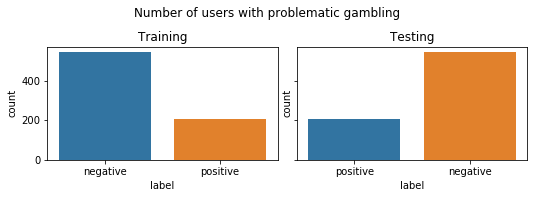

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 3))
ax1.set_title("Training")
ax2.set_title("Testing")
fig.suptitle("Number of users with problematic gambling")
sns.countplot(x="label", data=df_train, ax=ax1)
sns.countplot(x="label", data=df_test, ax=ax2)
plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

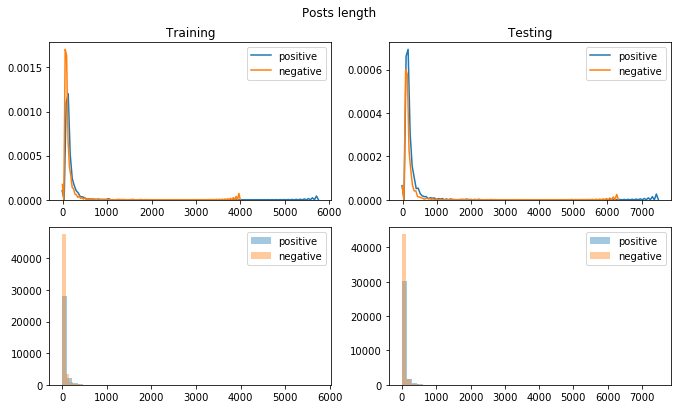

In [13]:
num_tokens_train = df_train.groupby("label").agg({"num_tokens": sum})
num_tokens_train = num_tokens_train.num_tokens.apply(lambda x: np.array(x))
num_tokens_train.apply(lambda x: x.sort())

num_tokens_test = df_test.groupby("label").agg({"num_tokens": sum})
num_tokens_test = num_tokens_test.num_tokens.apply(lambda x: np.array(x))
num_tokens_test.apply(lambda x: x.sort())

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))

axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Posts length")

sns.kdeplot(num_tokens_train["positive"], ax=axis[0, 0], label="positive")
sns.kdeplot(num_tokens_train["negative"], ax=axis[0, 0], label="negative")

sns.kdeplot(num_tokens_test["positive"], ax=axis[0, 1], label="positive")
sns.kdeplot(num_tokens_test["negative"], ax=axis[0, 1], label="negative")

sns.distplot(num_tokens_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.distplot(num_tokens_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.distplot(num_tokens_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.distplot(num_tokens_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

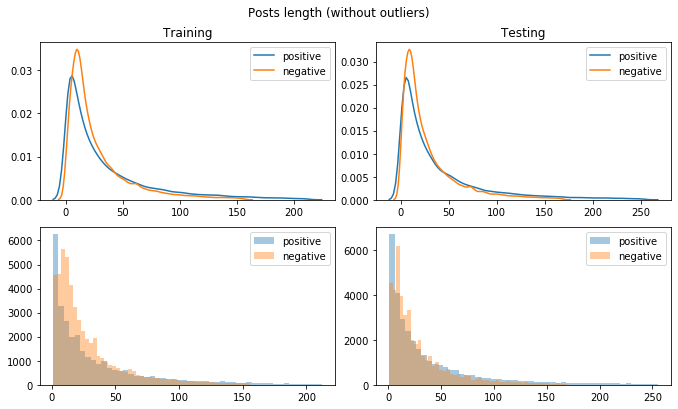

In [14]:
outlier_train_negative, outlier_train_positive = (
    np.quantile(num_tokens_train[0], 0.97),
    np.quantile(num_tokens_train[1], 0.97),
)
outlier_test_negative, outlier_test_positive = (
    np.quantile(num_tokens_test[0], 0.97),
    np.quantile(num_tokens_test[1], 0.97),
)

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Posts length (without outliers)")

without_outliers = num_tokens_train["positive"][
    num_tokens_train["positive"] < outlier_train_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="positive")
sns.distplot(without_outliers, ax=axis[1, 0], label="positive", kde=False)

without_outliers = num_tokens_train["negative"][
    num_tokens_train["negative"] < outlier_train_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="negative")
sns.distplot(without_outliers, ax=axis[1, 0], label="negative", kde=False)

without_outliers = num_tokens_test["positive"][
    num_tokens_test["positive"] < outlier_test_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="positive")
sns.distplot(without_outliers, ax=axis[1, 1], label="positive", kde=False)

without_outliers = num_tokens_test["negative"][
    num_tokens_test["negative"] < outlier_test_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="negative")
sns.distplot(without_outliers, ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

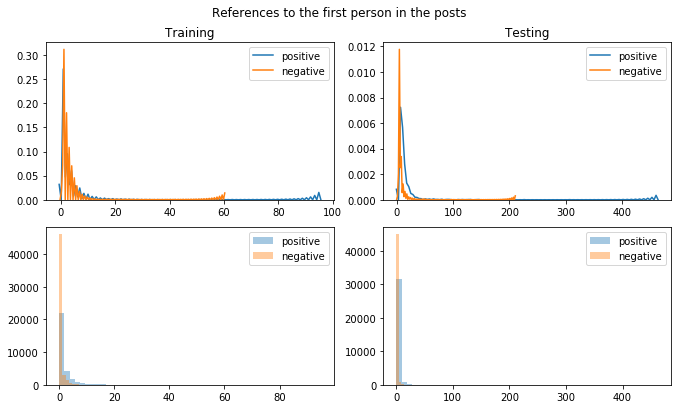

In [15]:
num_first_person_train = df_train.groupby("label").agg({"num_tokens_first_person": sum})
num_first_person_train = num_first_person_train.num_tokens_first_person.apply(
    lambda x: np.array(x)
)
num_first_person_train.apply(lambda x: x.sort())

num_first_person_test = df_test.groupby("label").agg({"num_tokens_first_person": sum})
num_first_person_test = num_first_person_test.num_tokens_first_person.apply(
    lambda x: np.array(x)
)
num_first_person_test.apply(lambda x: x.sort())

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("References to the first person in the posts")

sns.kdeplot(num_first_person_train["positive"], ax=axis[0, 0], label="positive")
sns.distplot(
    num_first_person_train["positive"], ax=axis[1, 0], label="positive", kde=False
)
sns.kdeplot(num_first_person_train["negative"], ax=axis[0, 0], label="negative")
sns.distplot(
    num_first_person_train["negative"], ax=axis[1, 0], label="negative", kde=False
)

sns.kdeplot(num_first_person_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(
    num_first_person_test["positive"], ax=axis[1, 1], label="positive", kde=False
)
sns.kdeplot(num_first_person_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(
    num_first_person_test["negative"], ax=axis[1, 1], label="negative", kde=False
)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

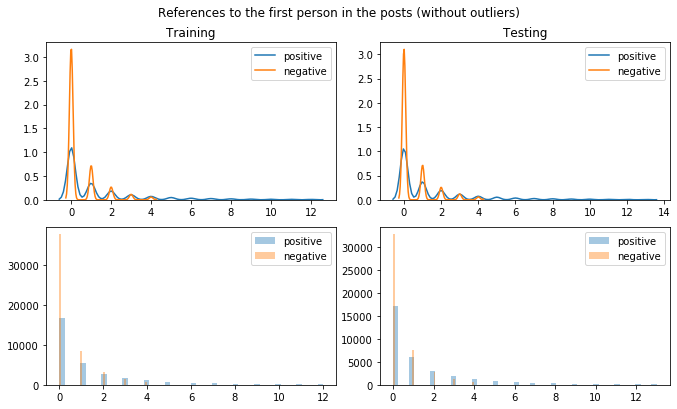

In [16]:
outlier_threshold = 0.98
outlier_train_negative, outlier_train_positive = (
    np.quantile(num_first_person_train[0], outlier_threshold),
    np.quantile(num_first_person_train[1], outlier_threshold),
)
outlier_test_negative, outlier_test_positive = (
    np.quantile(num_first_person_test[0], outlier_threshold),
    np.quantile(num_first_person_test[1], outlier_threshold),
)

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("References to the first person in the posts (without outliers)")

without_outliers = num_first_person_train["positive"][
    num_first_person_train["positive"] < outlier_train_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="positive")
sns.distplot(without_outliers, ax=axis[1, 0], label="positive", kde=False)

without_outliers = num_first_person_train["negative"][
    num_first_person_train["negative"] < outlier_train_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="negative")
sns.distplot(without_outliers, ax=axis[1, 0], label="negative", kde=False)

without_outliers = num_first_person_test["positive"][
    num_first_person_test["positive"] < outlier_test_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="positive")
sns.distplot(without_outliers, ax=axis[1, 1], label="positive", kde=False)

without_outliers = num_first_person_test["negative"][
    num_first_person_test["negative"] < outlier_test_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="negative")
sns.distplot(without_outliers, ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

## Latent Dirichlet Allocation (LDA)
We apply LDA to obtain the most relevant topics from documents of both positive and negative people with problematic gambling, both for training and for testing.

In [17]:
posts = []
for user_posts in df_train.posts:
    aux_list_posts = []
    for post in user_posts:
        for word in post.split():
            aux_list_posts.append(word)
    posts.append(aux_list_posts)

In [18]:
corpus, id2word, bigram = get_corpus_id2word(posts)

In [19]:
lda_train = gensim.models.LdaModel(
    corpus=corpus,
    num_topics=15,
    id2word=id2word,
    chunksize=100,
    passes=50,
    eval_every=1,
    random_state=30,
    per_word_topics=True,
)

In [20]:
lda_train.print_topics(num_topics=-1, num_words=20)

[(0,
  '0.004*"i\'ve" + 0.003*"old" + 0.003*"went" + 0.003*"little" + 0.003*"i_am" + 0.003*"man" + 0.003*"home" + 0.003*"found" + 0.003*"a_few" + 0.003*"thanks" + 0.003*"show" + 0.003*"love" + 0.003*"yeah" + 0.002*"house" + 0.002*"car" + 0.002*"guy" + 0.002*"didn\'t" + 0.002*"left" + 0.002*"took" + 0.002*"started"'),
 (1,
  '0.000*"studying" + 0.000*"sucking" + 0.000*"sums" + 0.000*"step_forward" + 0.000*"surprisingly" + 0.000*"suv" + 0.000*"suffered" + 0.000*"suppose" + 0.000*"sticks" + 0.000*"strip" + 0.000*"stressing" + 0.000*"stressful" + 0.000*"streams" + 0.000*"stove" + 0.000*"stopped_gambling" + 0.000*"stole" + 0.000*"stock_market" + 0.000*"stuffed" + 0.000*"stupidly" + 0.000*"sucker"'),
 (2,
  '0.009*"that\'s" + 0.005*"they\'re" + 0.005*"doesn\'t" + 0.005*"can\'t" + 0.005*"isn\'t" + 0.004*"didn\'t" + 0.004*"he\'s" + 0.004*"there\'s" + 0.003*"you\'re" + 0.003*"shit" + 0.003*"mean" + 0.003*"world" + 0.003*"though" + 0.003*"won\'t" + 0.003*"yeah" + 0.002*"aren\'t" + 0.002*"person"

In [21]:
top_topics = lda_train.get_document_topics(corpus[1], minimum_probability=0.0)
topic_vec = [top_topics[i][1] for i in range(10)]
top_topics, topic_vec

([(0, 0.00028882883),
  (1, 0.00028882807),
  (2, 0.00028882886),
  (3, 0.00028882807),
  (4, 0.034424312),
  (5, 0.00028882854),
  (6, 0.13143317),
  (7, 0.64482933),
  (8, 0.00028882825),
  (9, 0.00028882807),
  (10, 0.0002888284),
  (11, 0.18613607),
  (12, 0.00028882854),
  (13, 0.00028882874),
  (14, 0.00028882807)],
 [0.00028882883,
  0.00028882807,
  0.00028882886,
  0.00028882807,
  0.034424312,
  0.00028882854,
  0.13143317,
  0.64482933,
  0.00028882825,
  0.00028882807])

In [22]:
posts_test = []
for user_posts in df_test.posts:
    aux_list_posts = []
    for post in user_posts:
        for word in post.split():
            aux_list_posts.append(word)
    posts_test.append(aux_list_posts)

In [23]:
posts_test[0][:10]

['commenting',
 'because',
 'i',
 'was',
 'looking',
 'for',
 'this',
 'post',
 'very',
 'grateful']

In [24]:
corpus_test, _, _ = get_corpus_id2word(posts_test, bigram_model=bigram, id2word=id2word)

In [25]:
top_topics_test = lda_train.get_document_topics(corpus_test[1], minimum_probability=0.0)
topic_vec_test = [top_topics_test[i][1] for i in range(10)]
top_topics_test, topic_vec_test

([(0, 0.14948292),
  (1, 4.0090843e-05),
  (2, 0.118849106),
  (3, 4.0090843e-05),
  (4, 0.07011219),
  (5, 0.042636644),
  (6, 0.14542678),
  (7, 0.29797244),
  (8, 0.022432167),
  (9, 4.0090843e-05),
  (10, 4.0090967e-05),
  (11, 0.15280713),
  (12, 4.009095e-05),
  (13, 4.0090963e-05),
  (14, 4.0090843e-05)],
 [0.14948292,
  4.0090843e-05,
  0.118849106,
  4.0090843e-05,
  0.07011219,
  0.042636644,
  0.14542678,
  0.29797244,
  0.022432167,
  4.0090843e-05])

## Graphs related to the posts sentiment analysis

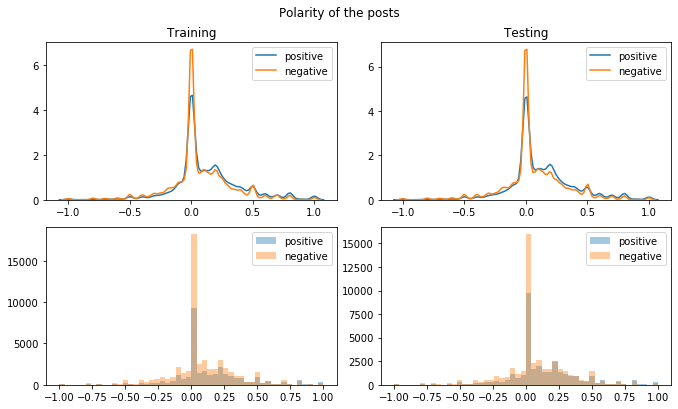

In [26]:
polarity_train = df_train.groupby("label").agg({"polarity": sum})
polarity_train = polarity_train.polarity.apply(lambda x: np.array(x))

polarity_test = df_test.groupby("label").agg({"polarity": sum})
polarity_test = polarity_test.polarity.apply(lambda x: np.array(x))

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Polarity of the posts")

sns.kdeplot(polarity_train["positive"], ax=axis[0, 0], label="positive")
sns.distplot(polarity_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.kdeplot(polarity_train["negative"], ax=axis[0, 0], label="negative")
sns.distplot(polarity_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.kdeplot(polarity_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(polarity_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.kdeplot(polarity_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(polarity_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

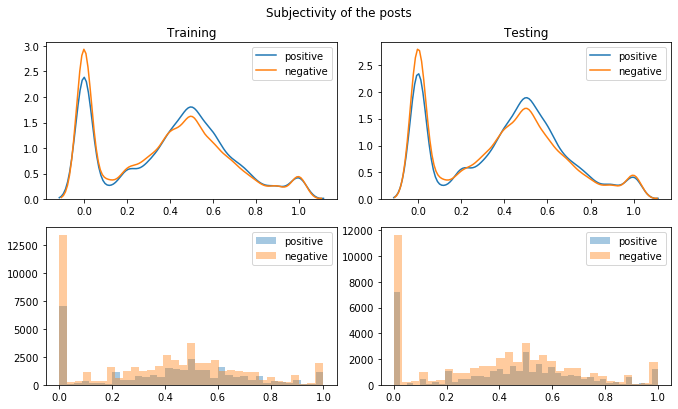

In [27]:
subjectivity_train = df_train.groupby("label").agg({"subjectivity": sum})
subjectivity_train = subjectivity_train.subjectivity.apply(lambda x: np.array(x))

subjectivity_test = df_test.groupby("label").agg({"subjectivity": sum})
subjectivity_test = subjectivity_test.subjectivity.apply(lambda x: np.array(x))

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Subjectivity of the posts")

sns.kdeplot(subjectivity_train["positive"], ax=axis[0, 0], label="positive")
sns.distplot(subjectivity_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.kdeplot(subjectivity_train["negative"], ax=axis[0, 0], label="negative")
sns.distplot(subjectivity_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.kdeplot(subjectivity_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(subjectivity_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.kdeplot(subjectivity_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(subjectivity_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

##  Word cloud

In [28]:
plain_train_posts = [p for _posts in df_train.posts for p in _posts]
plain_test_posts = [p for _posts in df_test.posts for p in _posts]

plain_posts = plain_train_posts + plain_test_posts

In [29]:
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b[\w']+\b", use_idf=True)
vectorizer.fit(plain_posts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern="(?u)\\b[\\w']+\\b",
                tokenizer=None, use_idf=True, vocabulary=None)

In [30]:
idx2word = {idx: word for (word, idx) in vectorizer.vocabulary_.items()}

In [31]:
idf_sort_idxs = np.argsort(vectorizer.idf_)

print("Top 10 words with biggest IDF")
for i in idf_sort_idxs[:10]:
    print(f"'{idx2word[i]}': {vectorizer.idf_[i]}")

Top 10 words with biggest IDF
'the': 1.6764235440175468
'to': 1.791283986875973
'a': 1.8939234288551572
'and': 1.9541824330470114
'i': 2.0273988124665223
'of': 2.1135144716162673
'is': 2.21539578085612
'in': 2.2295545680207707
'it': 2.240157547096831
'that': 2.292902693973863


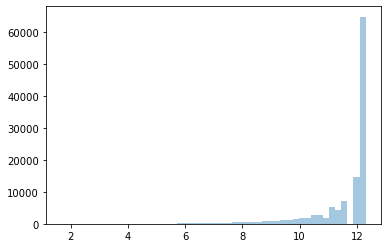

In [32]:
# Distribution of idf values throughout the dataset.
sns.distplot(vectorizer.idf_, kde=False);

In [33]:
min_percentile = 0.1
min_idf_allowed = np.percentile(vectorizer.idf_, min_percentile)

In [34]:
def get_words_in_vectorizer(posts_list):
    return [
        word
        for post in posts_list
        for word in post.split()
        if (word in vectorizer.vocabulary_)
        and (vectorizer.idf_[vectorizer.vocabulary_[word]] > min_idf_allowed)
    ]

### Training corpus

In [35]:
users_posts = df_train.posts

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_users_posts = pool.map(get_words_in_vectorizer, users_posts)
result_users_posts = [" ".join(r) for r in result_users_posts]
result_users_posts = " ".join(result_users_posts)

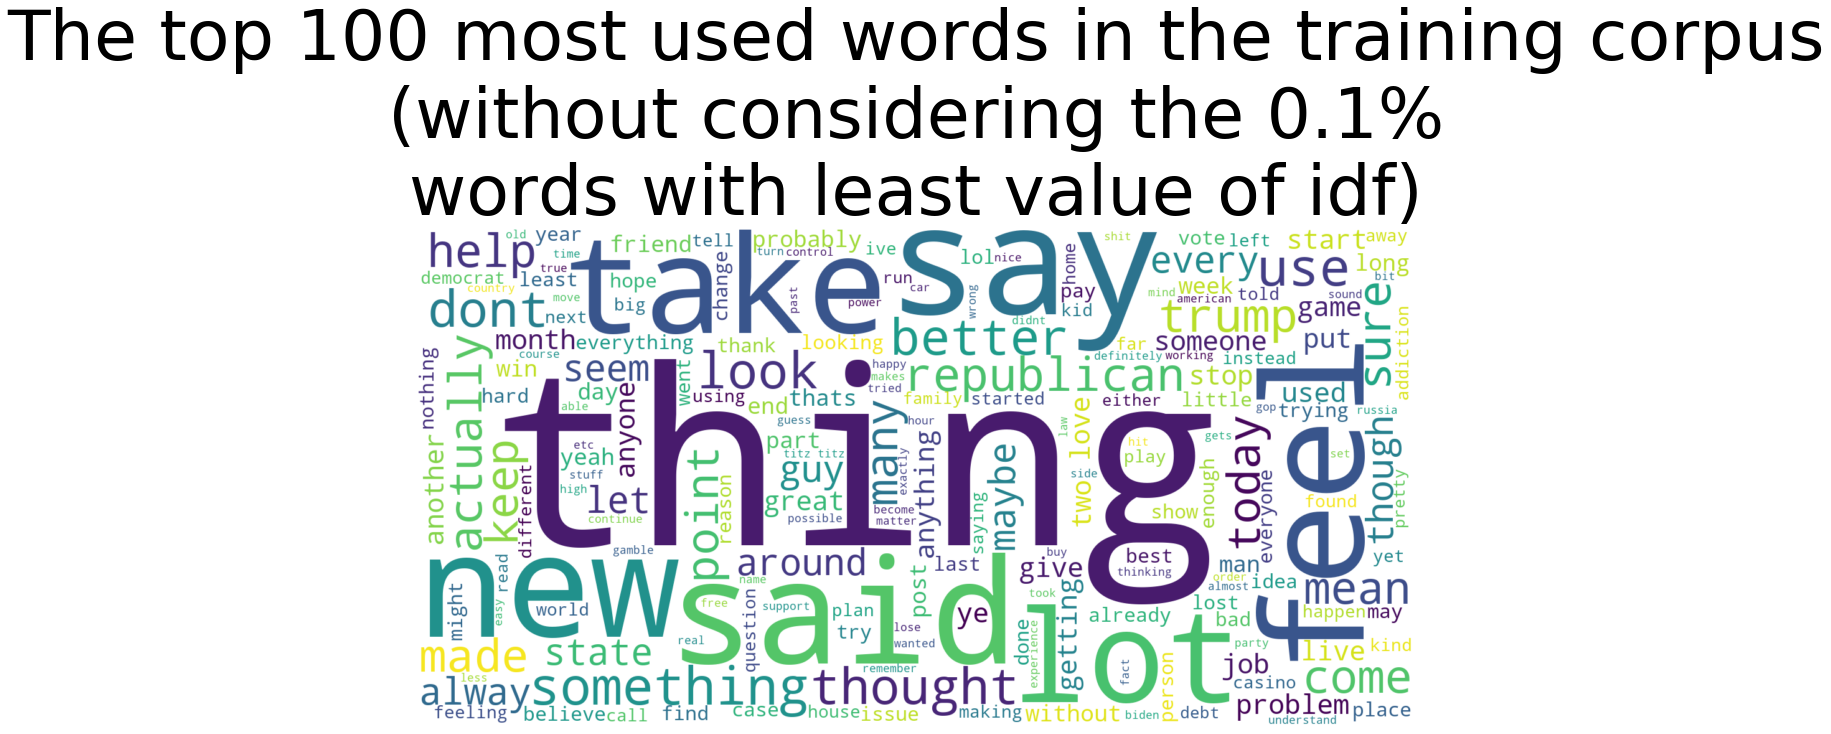

In [36]:
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(
    result_users_posts
)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the training corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

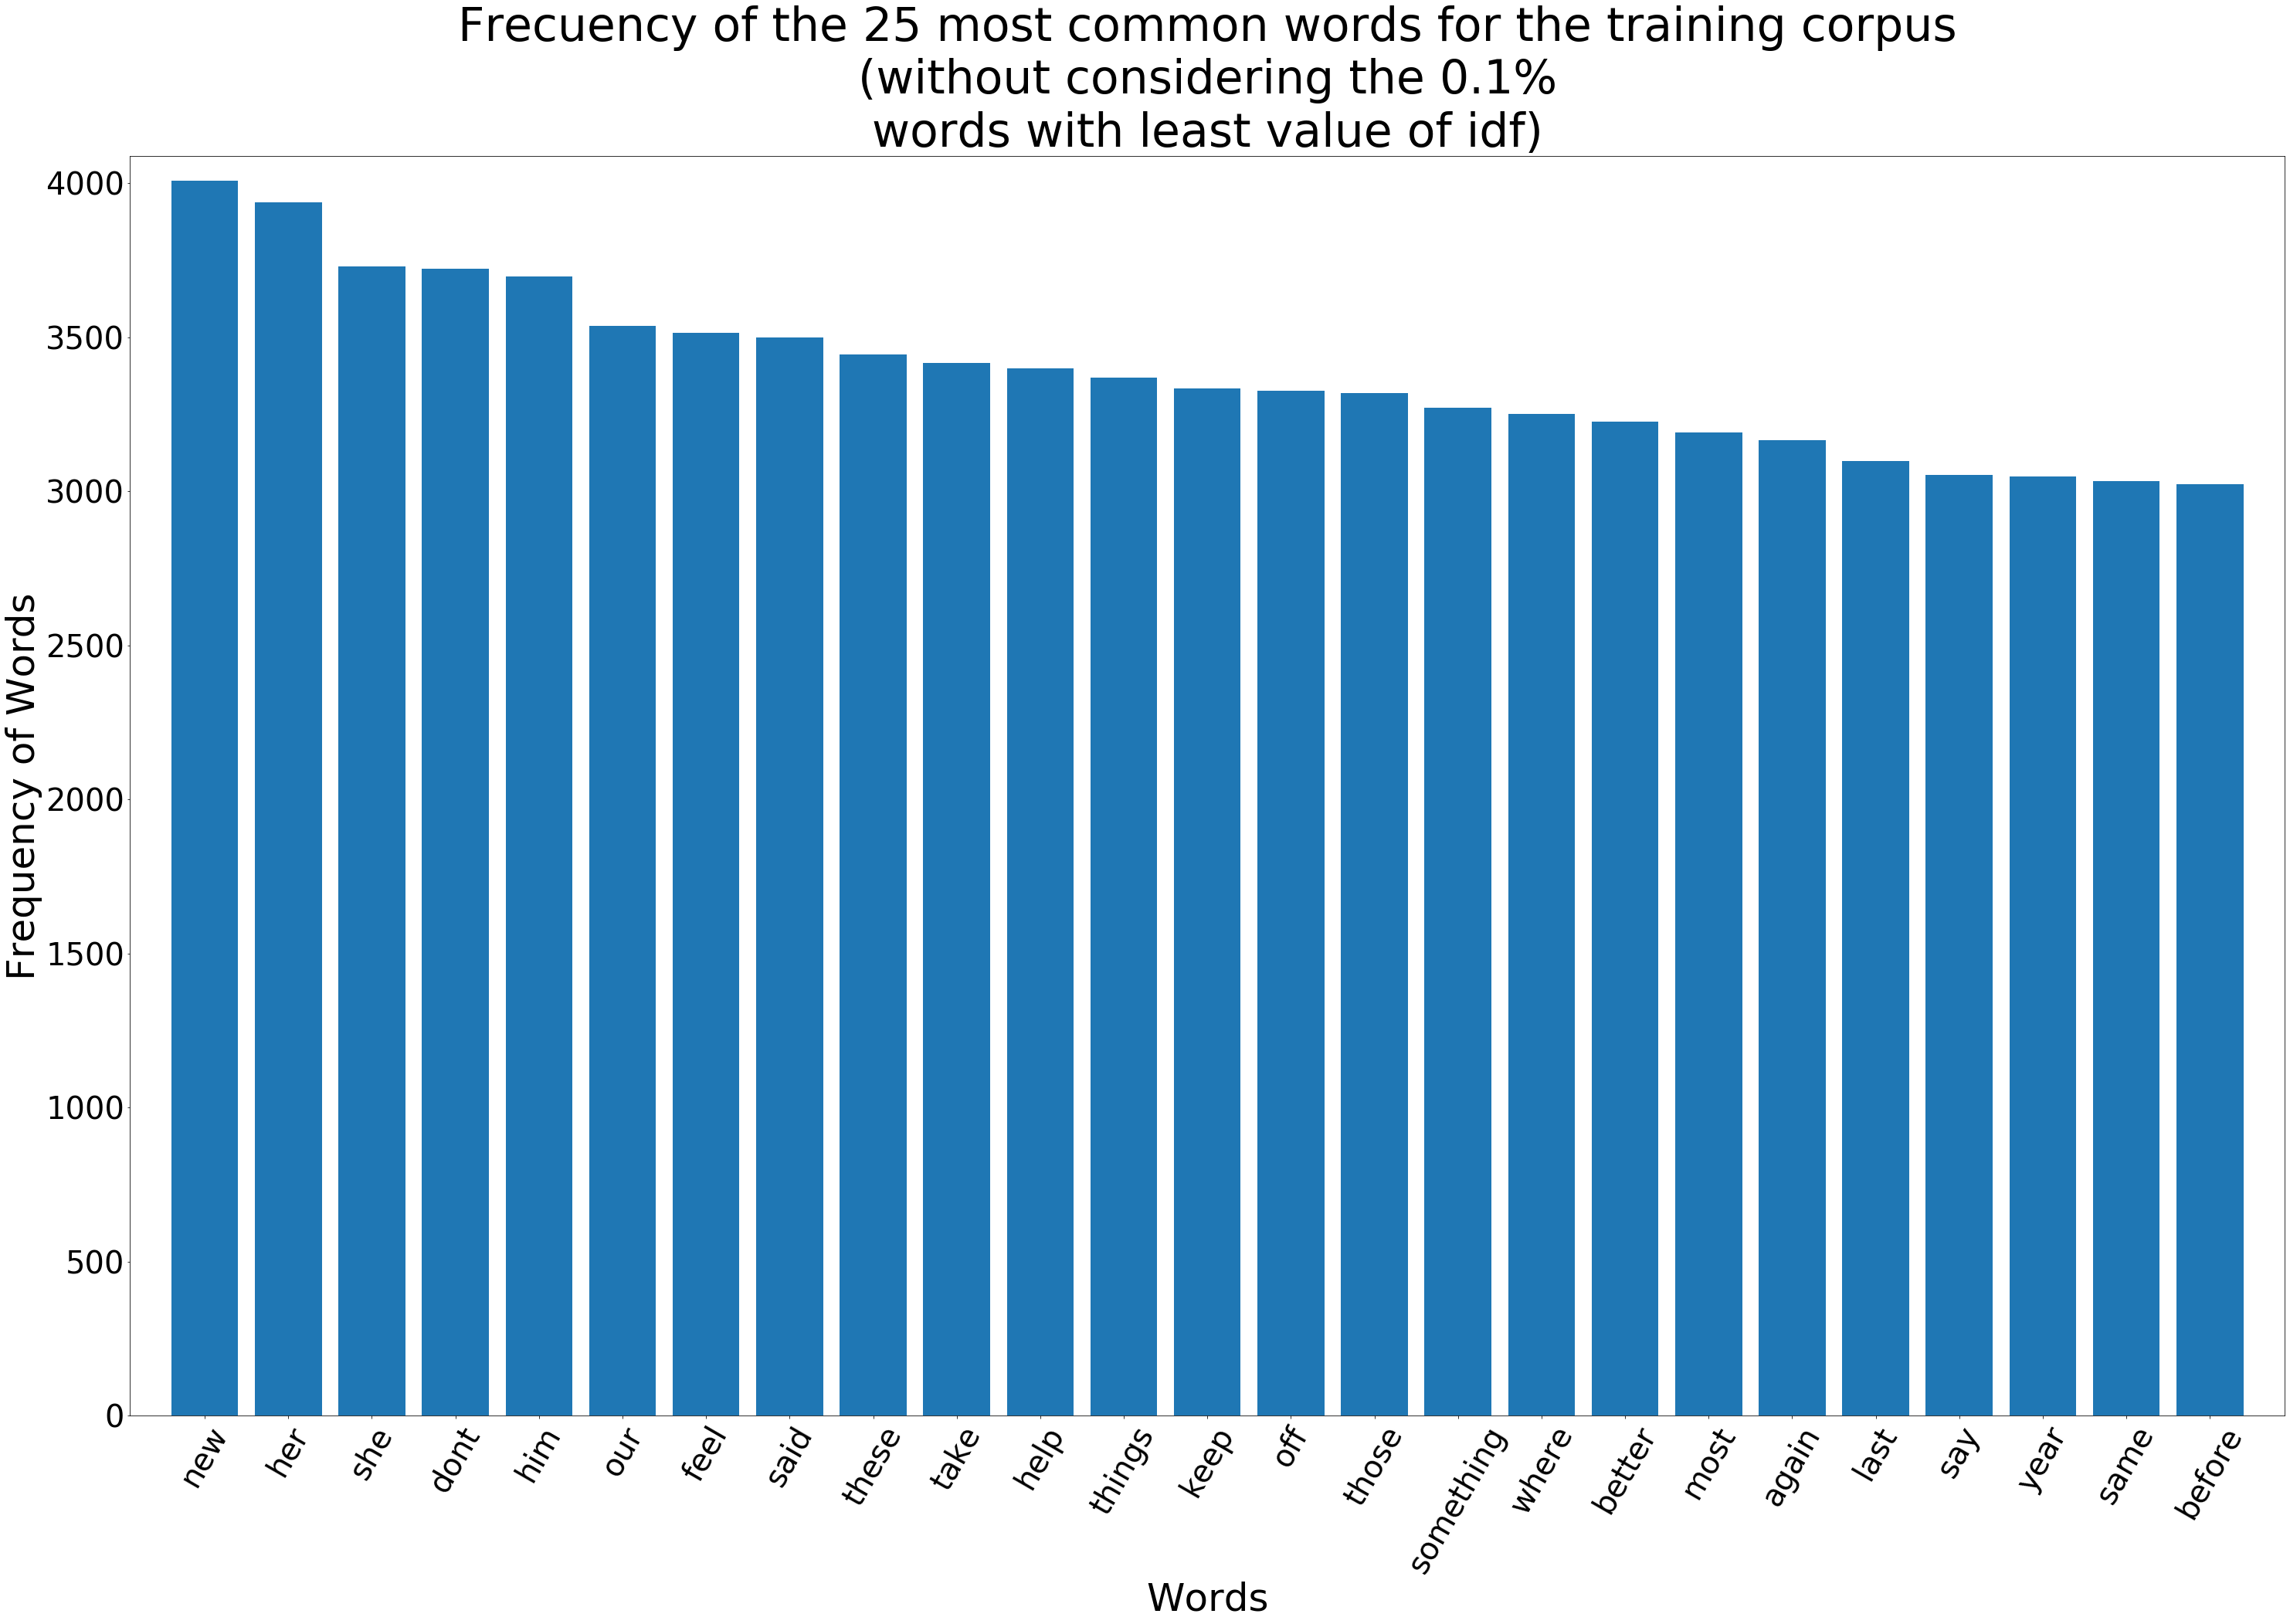

In [37]:
mostcommon_small_training = FreqDist(result_users_posts.split()).most_common(25)

x, y = zip(*mostcommon_small_training)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the training corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for positive users in the training corpus

In [38]:
positive_users_posts = df_train.posts[df_train.label == "positive"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_positive_users_posts = pool.map(
        get_words_in_vectorizer, positive_users_posts
    )
result_positive_users_posts = [" ".join(r) for r in result_positive_users_posts]
result_positive_users_posts = " ".join(result_positive_users_posts)

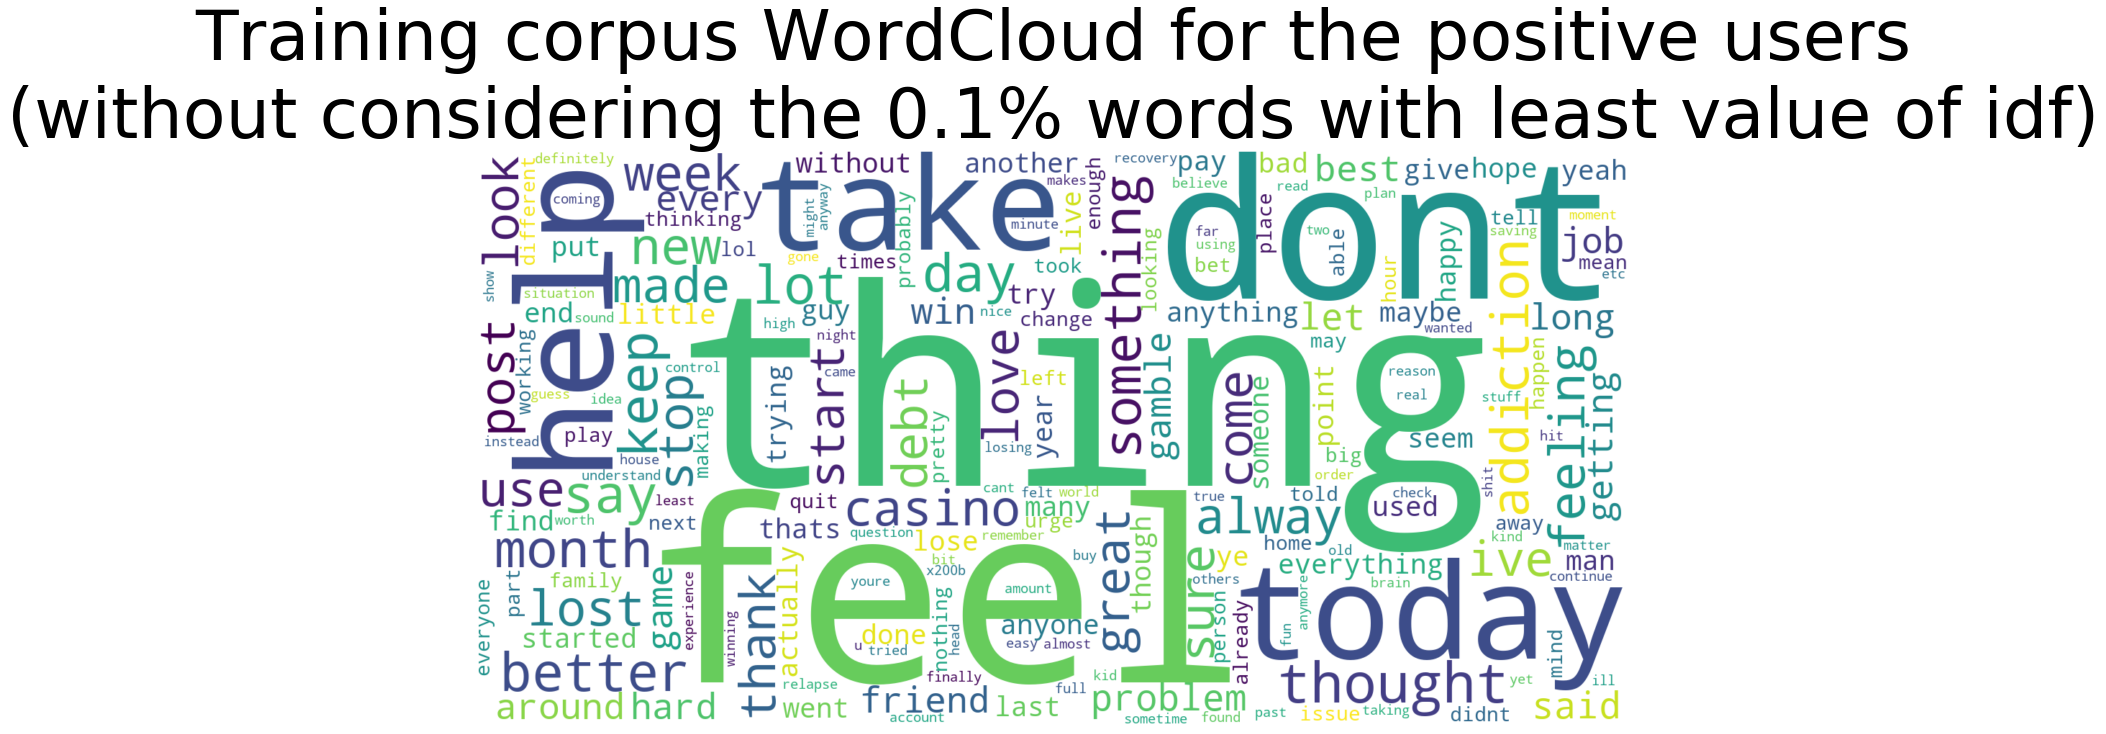

In [39]:
positive_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_positive_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "Training corpus WordCloud for the positive users\n(without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

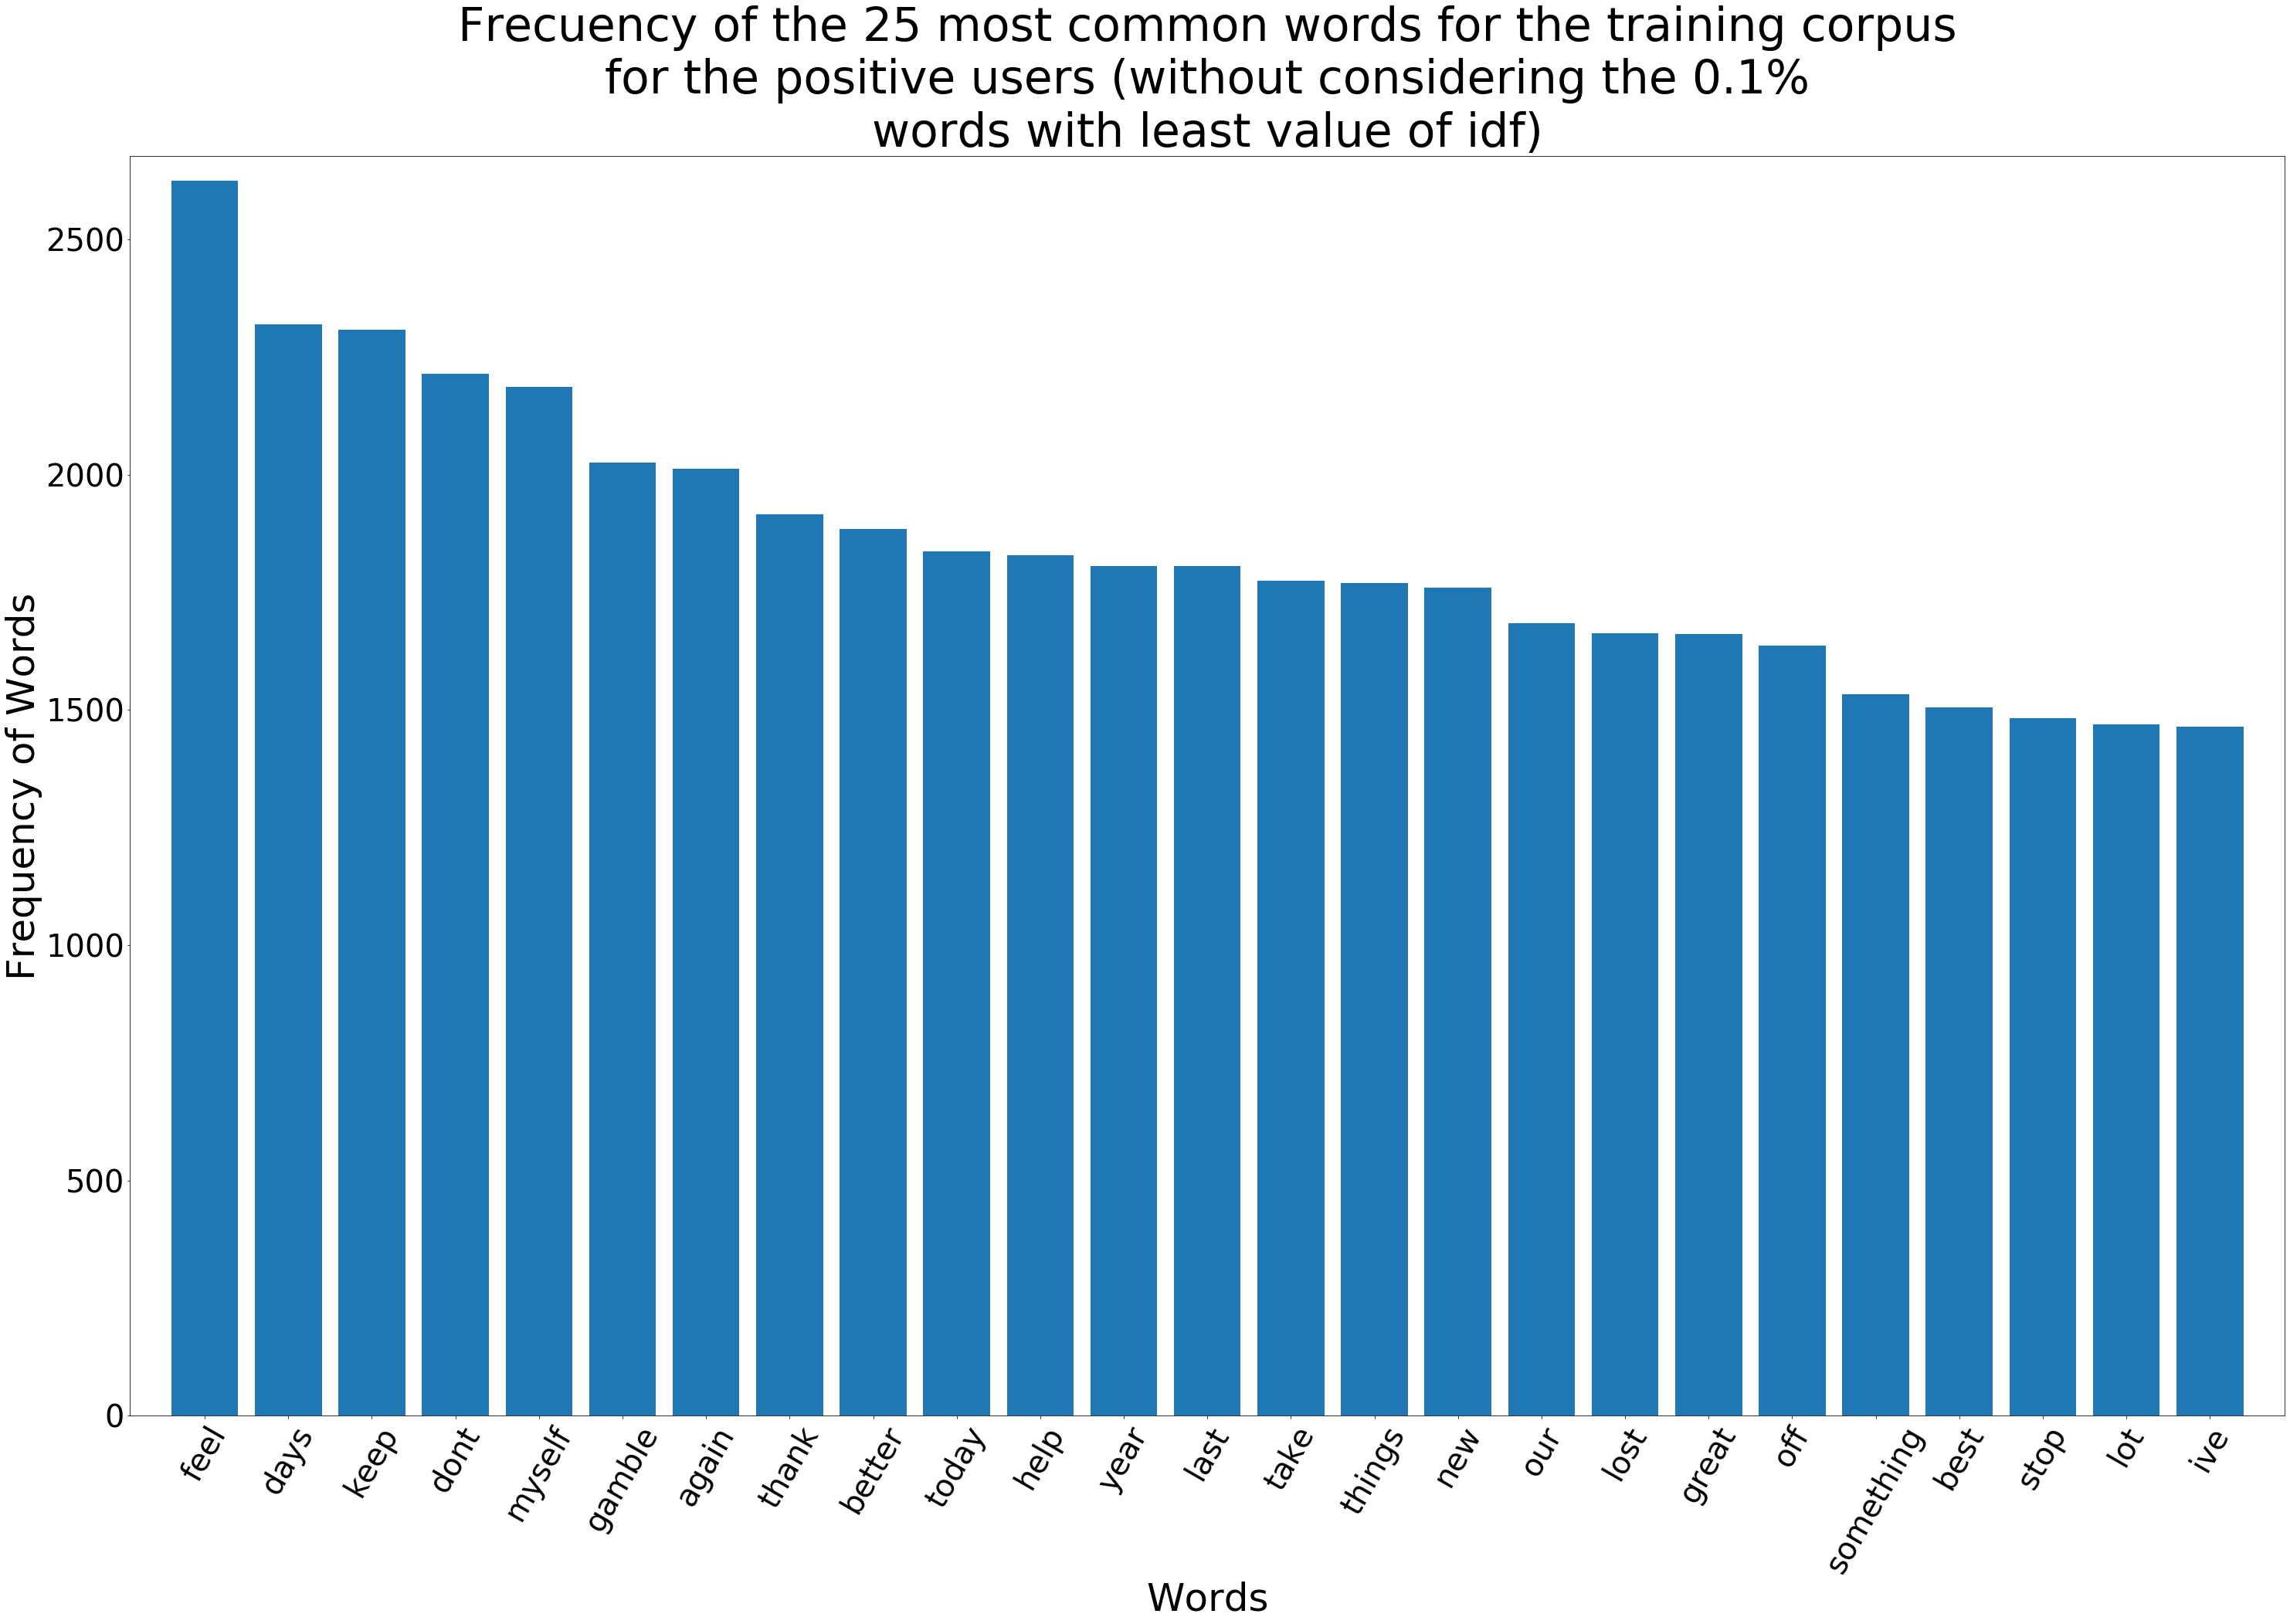

In [40]:
positive_mostcommon_small = FreqDist(result_positive_users_posts.split()).most_common(
    25
)

x, y = zip(*positive_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the training corpus\nfor the positive users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for negative users in the training corpus

In [41]:
negative_users_posts = df_train.posts[df_train.label == "negative"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_negative_users_posts = pool.map(
        get_words_in_vectorizer, negative_users_posts
    )
result_negative_users_posts = [" ".join(r) for r in result_negative_users_posts]
result_negative_users_posts = " ".join(result_negative_users_posts)

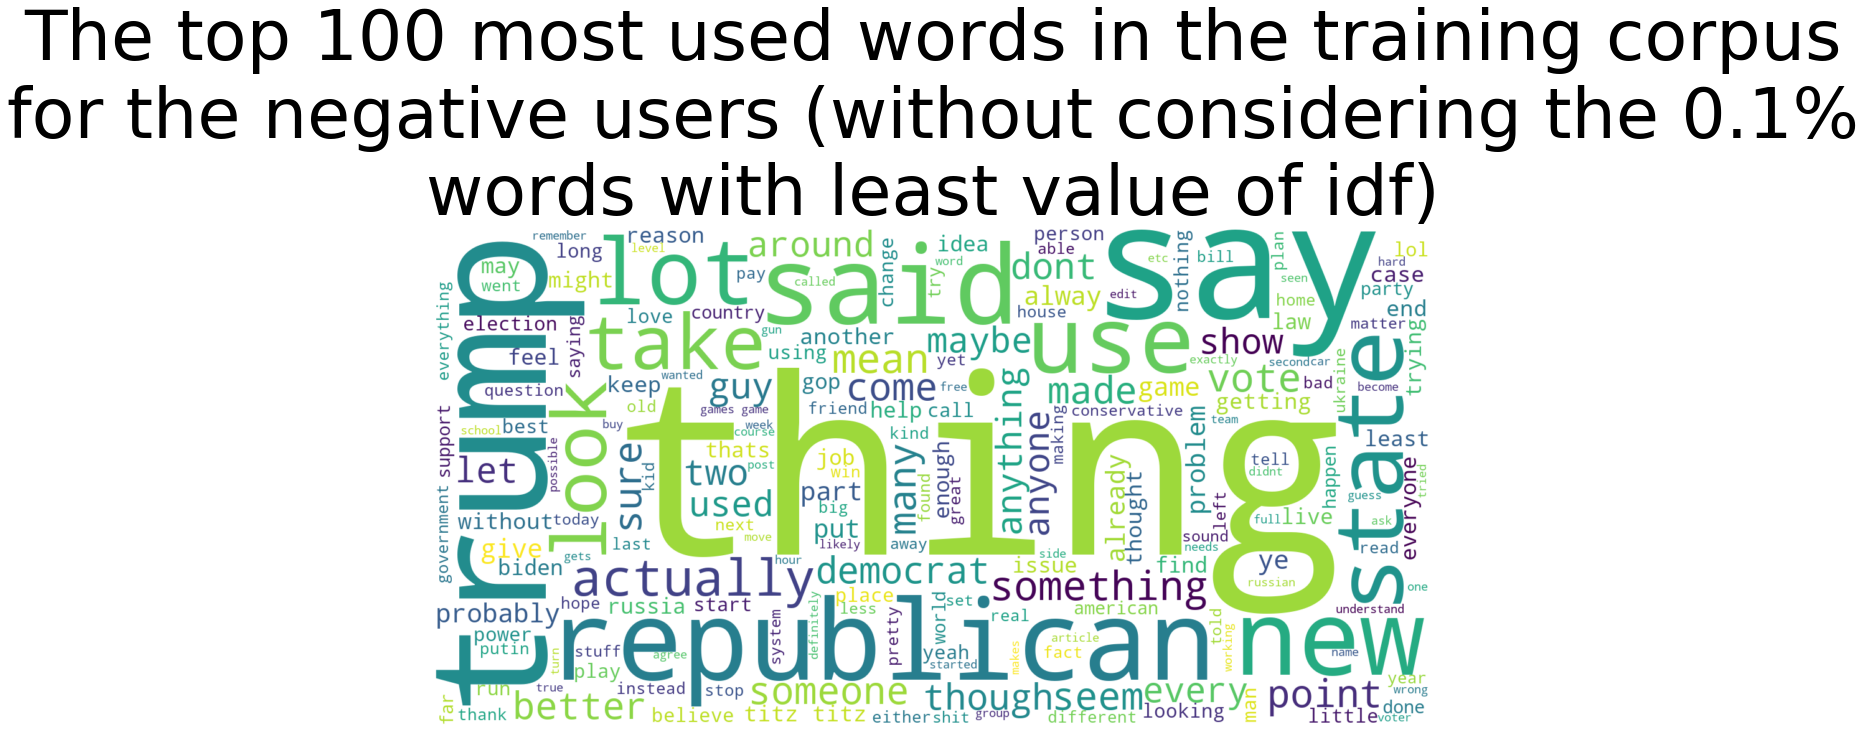

In [42]:
negative_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_negative_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the training corpus\nfor the negative users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

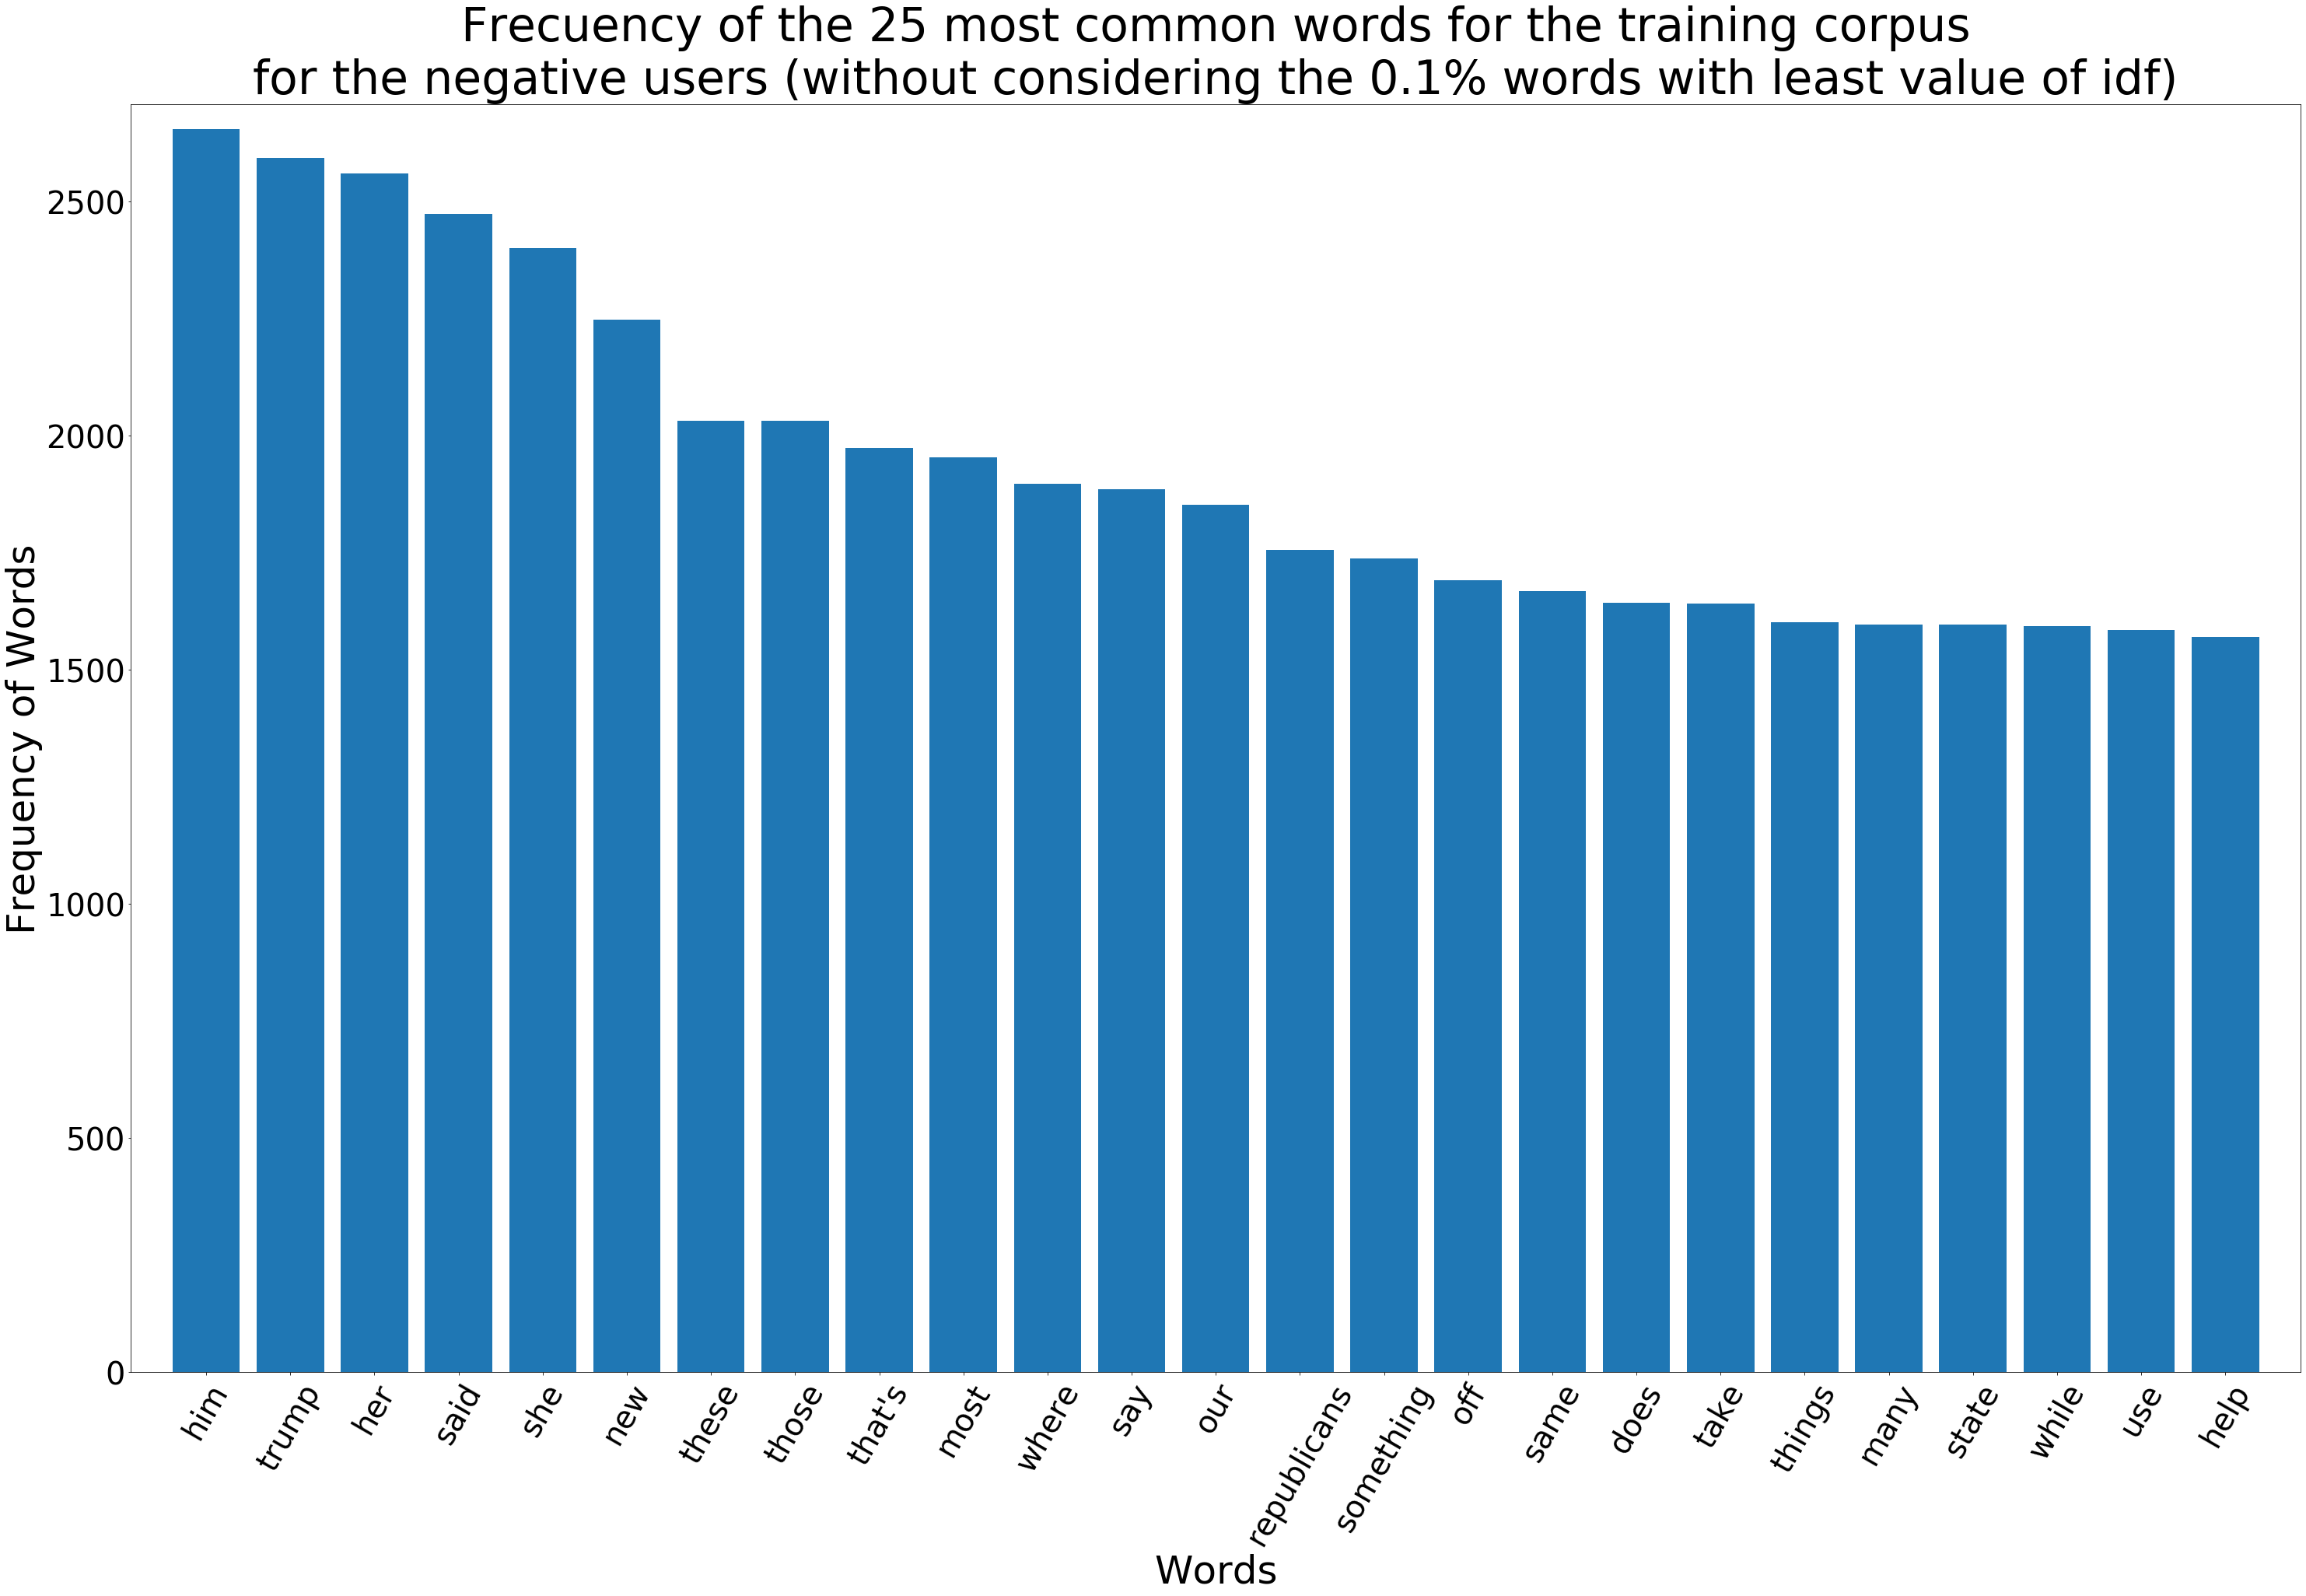

In [43]:
negative_mostcommon_small = FreqDist(result_negative_users_posts.split()).most_common(
    25
)

x, y = zip(*negative_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the training corpus\nfor the negative users (without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=60,
)
plt.show()

### Testing corpus

In [44]:
users_posts = df_test.posts

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_users_posts = pool.map(get_words_in_vectorizer, users_posts)
result_users_posts = [" ".join(r) for r in result_users_posts]
result_users_posts = " ".join(result_users_posts)

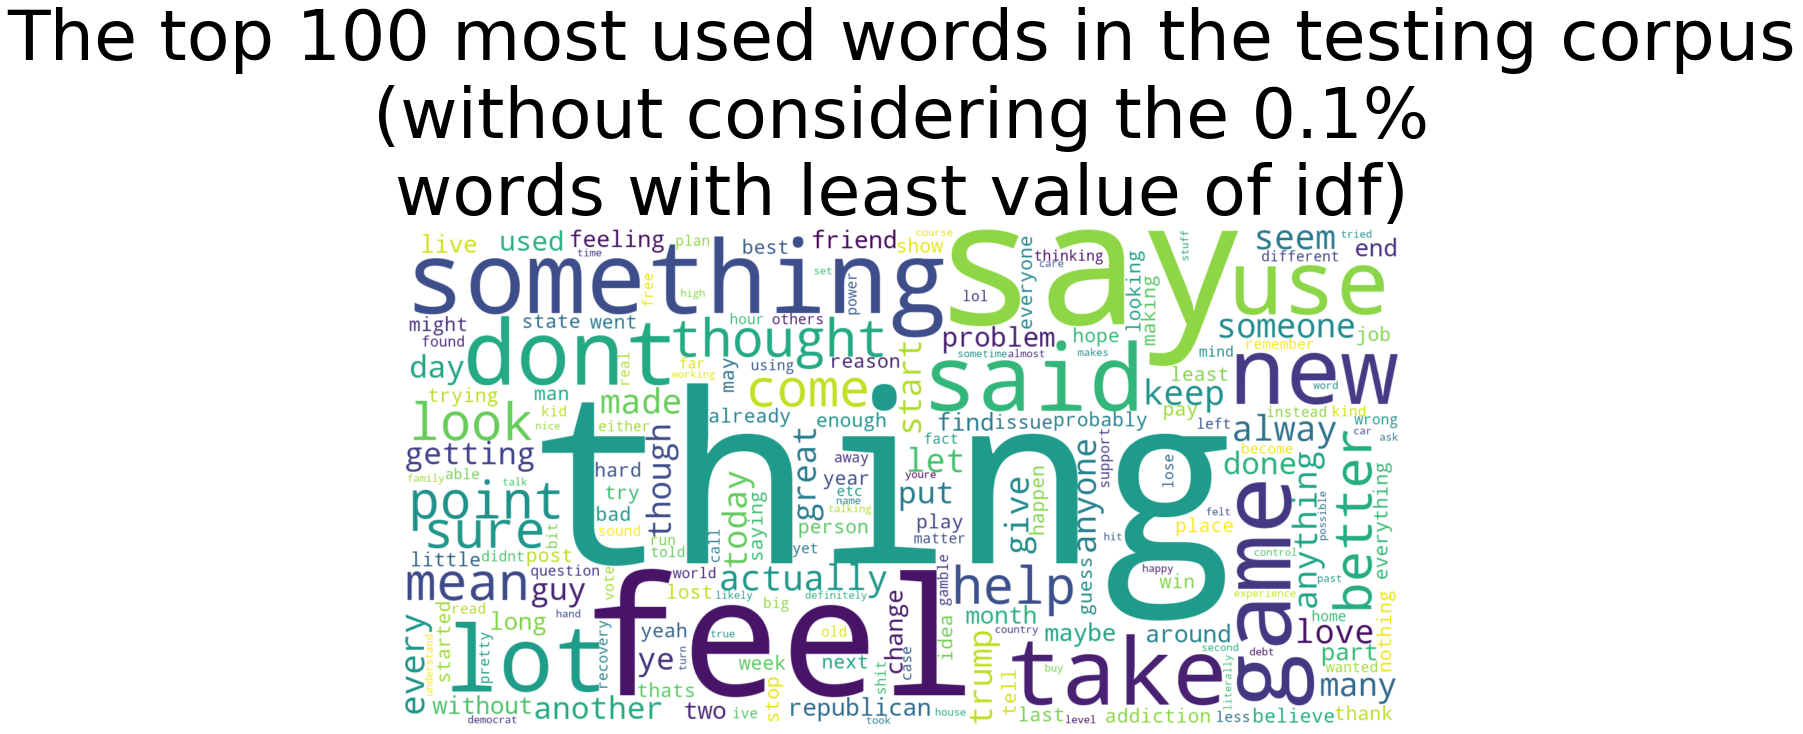

In [45]:
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(
    result_users_posts
)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the testing corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

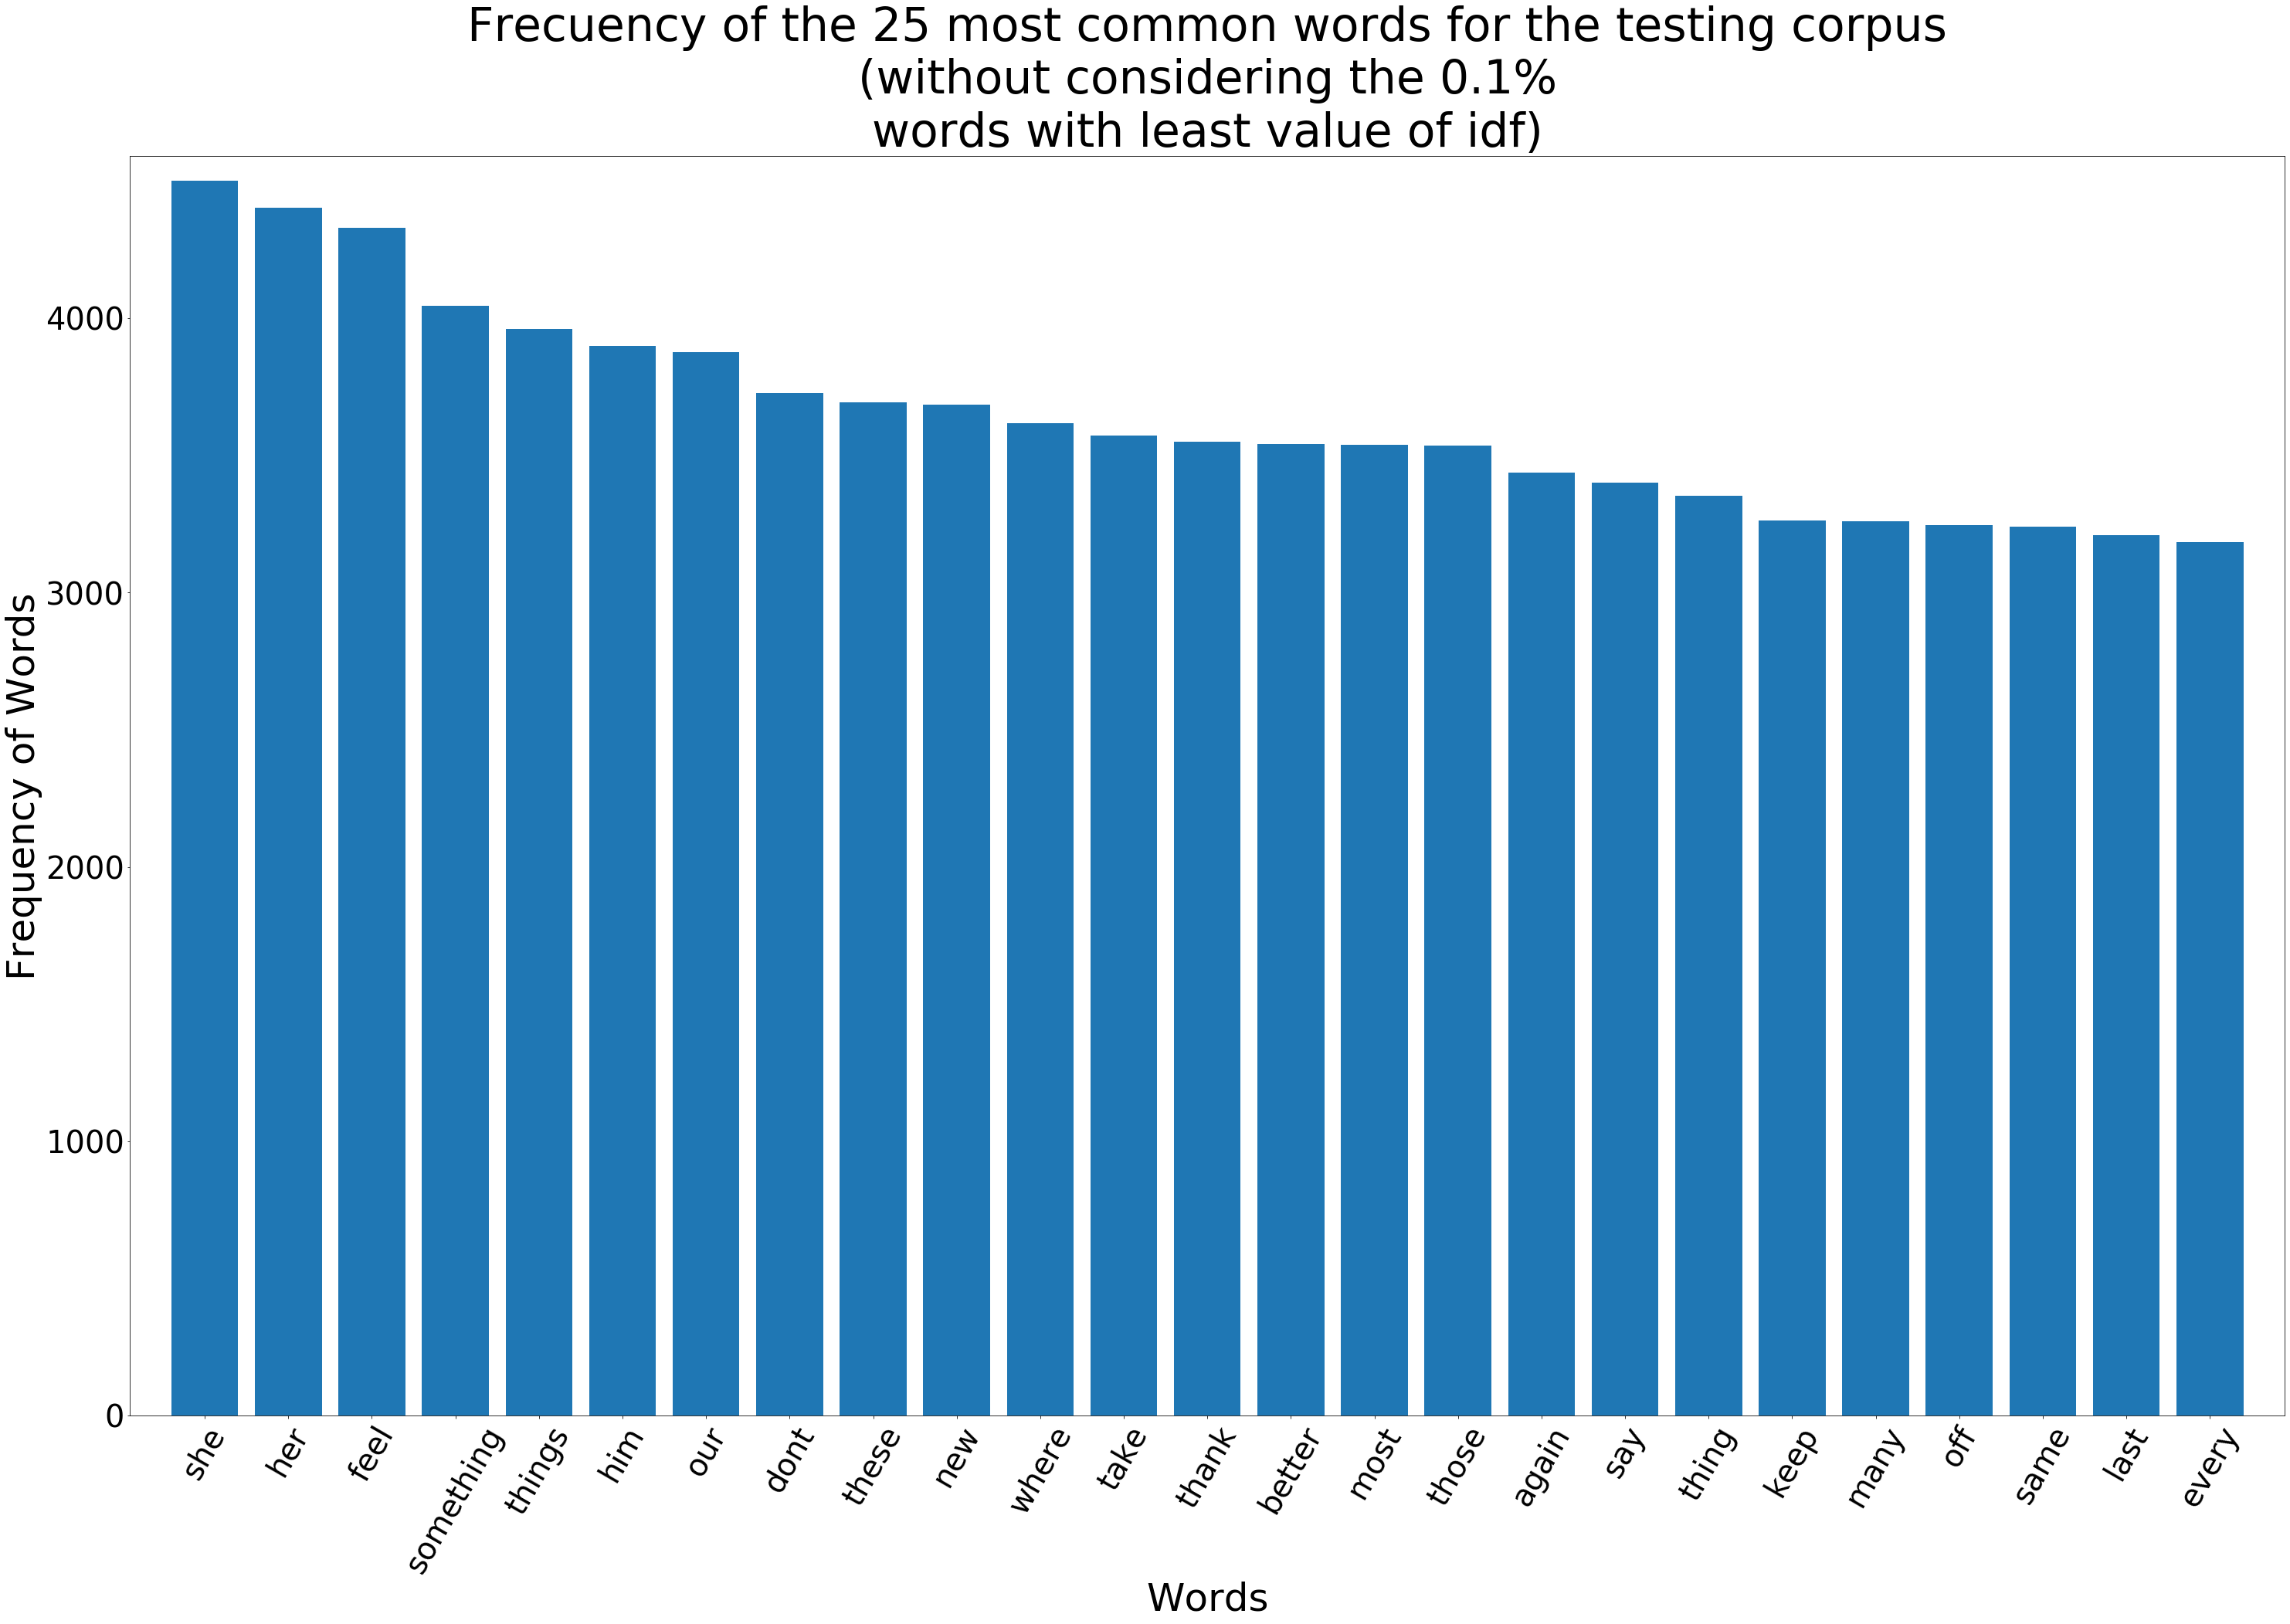

In [46]:
mostcommon_small = FreqDist(result_users_posts.split()).most_common(25)

x, y = zip(*mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the testing corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for positive users in the testing corpus

In [47]:
positive_users_posts = df_test.posts[df_test.label == "positive"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_positive_users_posts = pool.map(
        get_words_in_vectorizer, positive_users_posts
    )
result_positive_users_posts = [" ".join(r) for r in result_positive_users_posts]
result_positive_users_posts = " ".join(result_positive_users_posts)

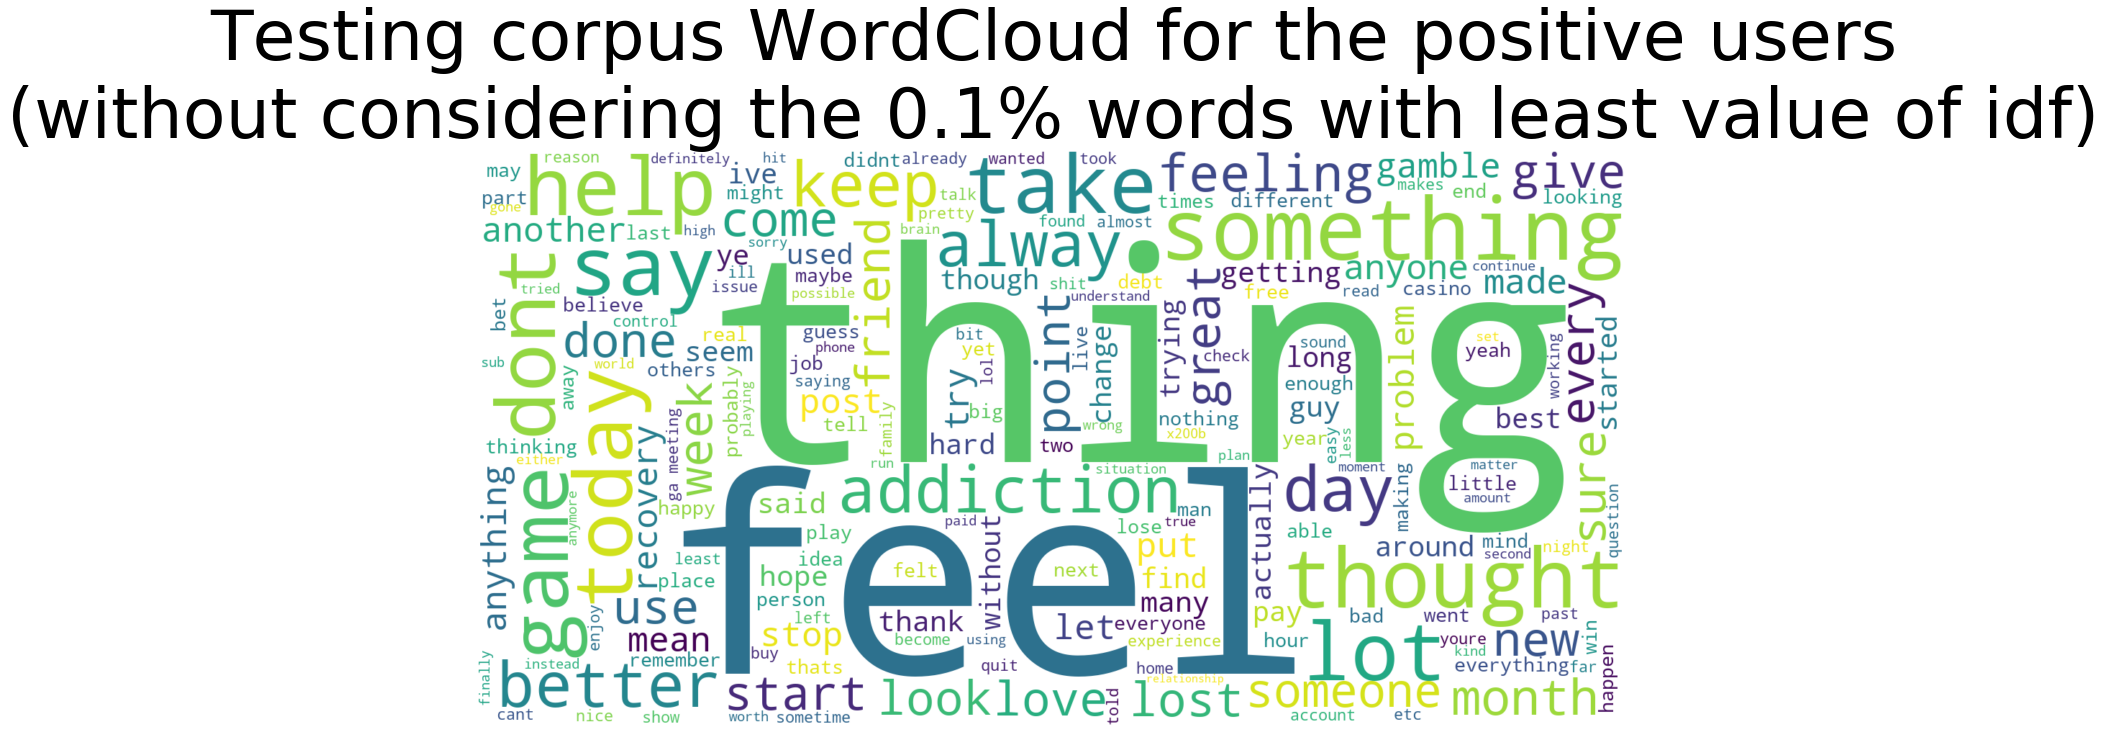

In [48]:
positive_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_positive_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "Testing corpus WordCloud for the positive users\n(without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

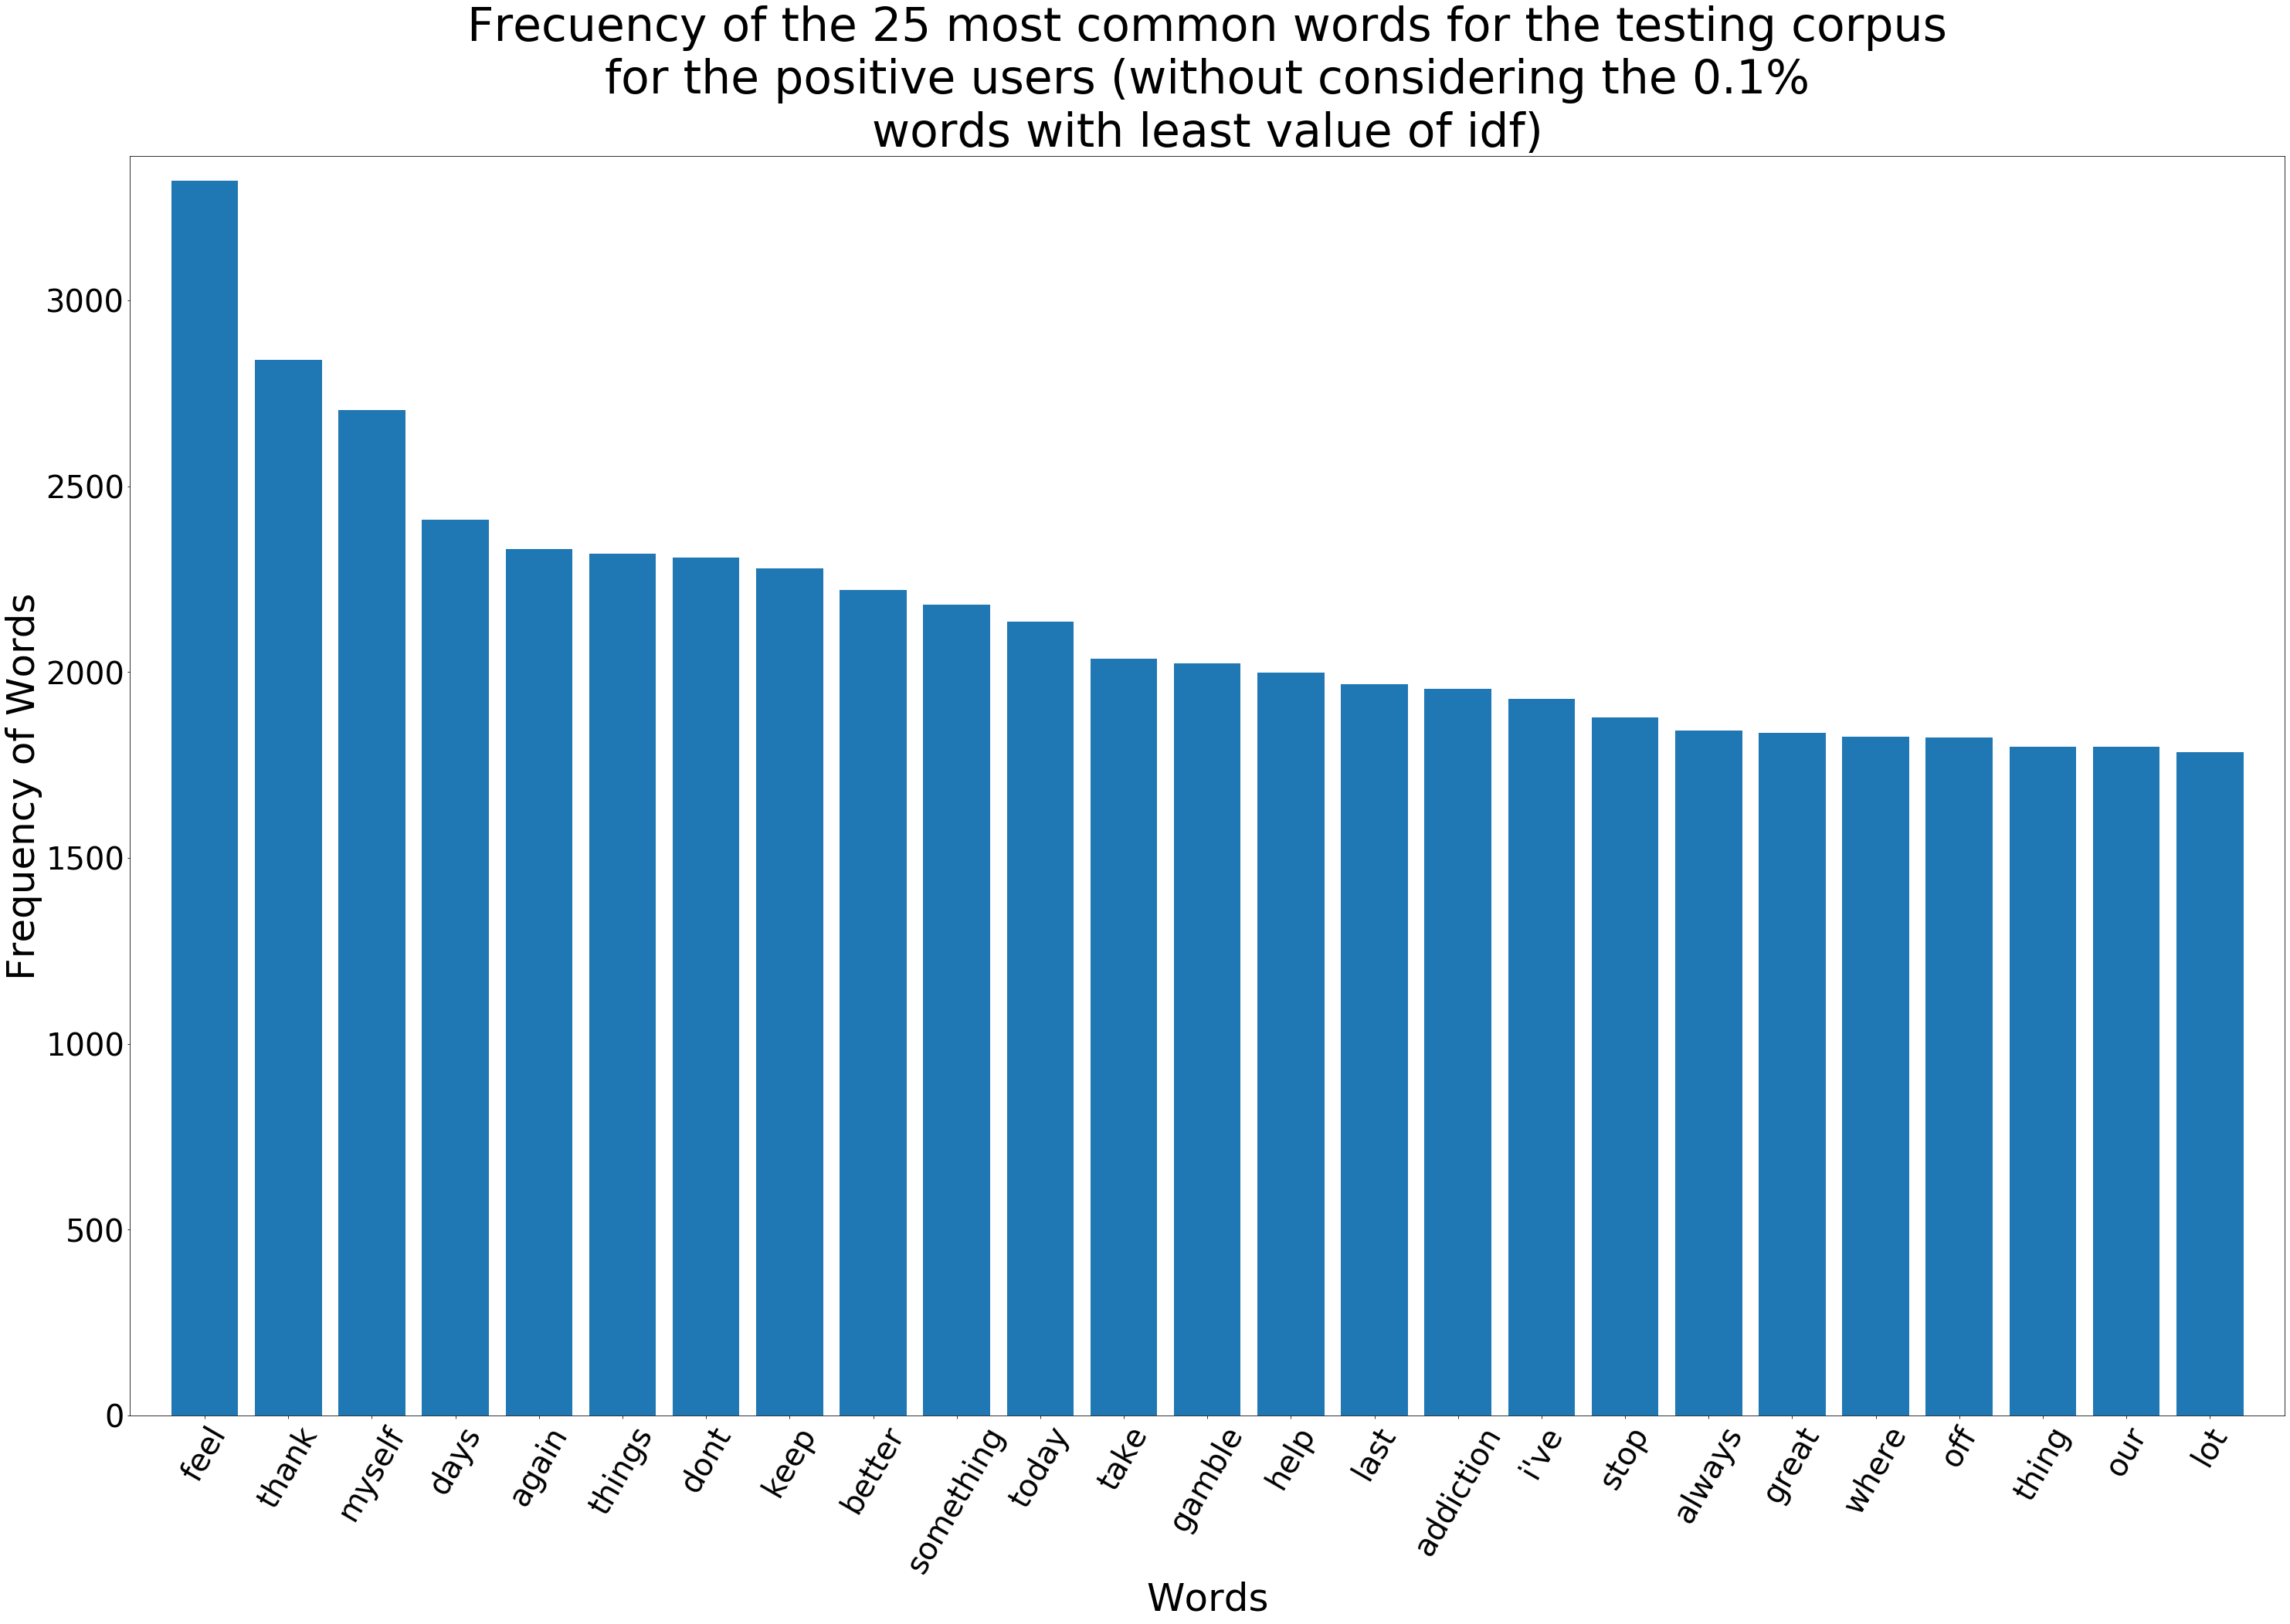

In [49]:
positive_mostcommon_small = FreqDist(result_positive_users_posts.split()).most_common(
    25
)

x, y = zip(*positive_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the testing corpus\nfor the positive users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for negative users in the testing corpus

In [50]:
negative_users_posts = df_test.posts[df_test.label == "negative"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_negative_users_posts = pool.map(
        get_words_in_vectorizer, negative_users_posts
    )
result_negative_users_posts = [" ".join(r) for r in result_negative_users_posts]
result_negative_users_posts = " ".join(result_negative_users_posts)

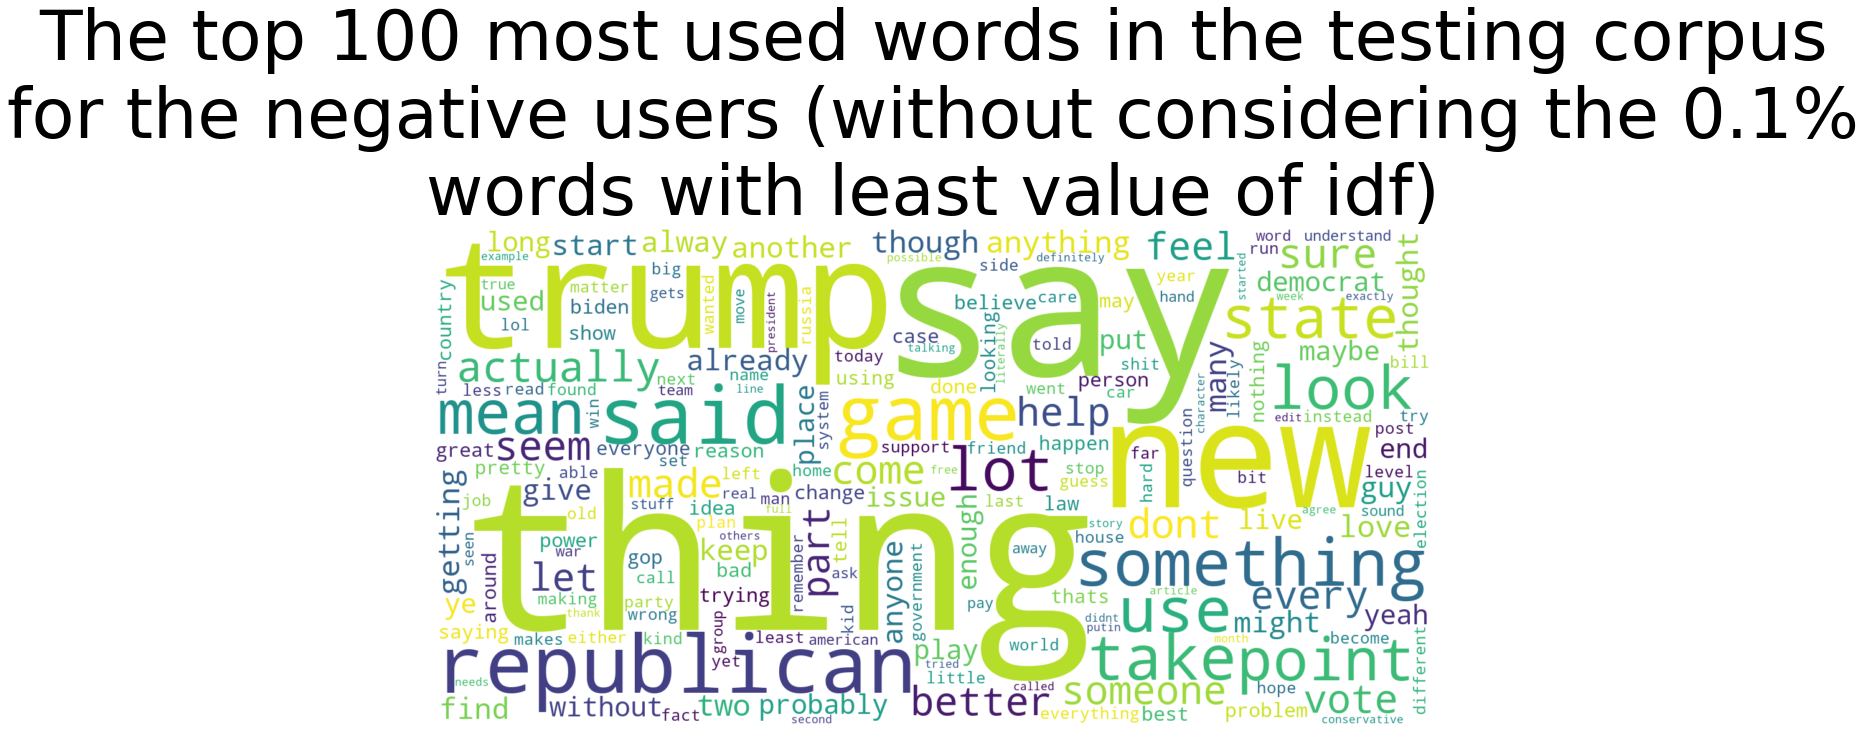

In [51]:
negative_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_negative_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the testing corpus\nfor the negative users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

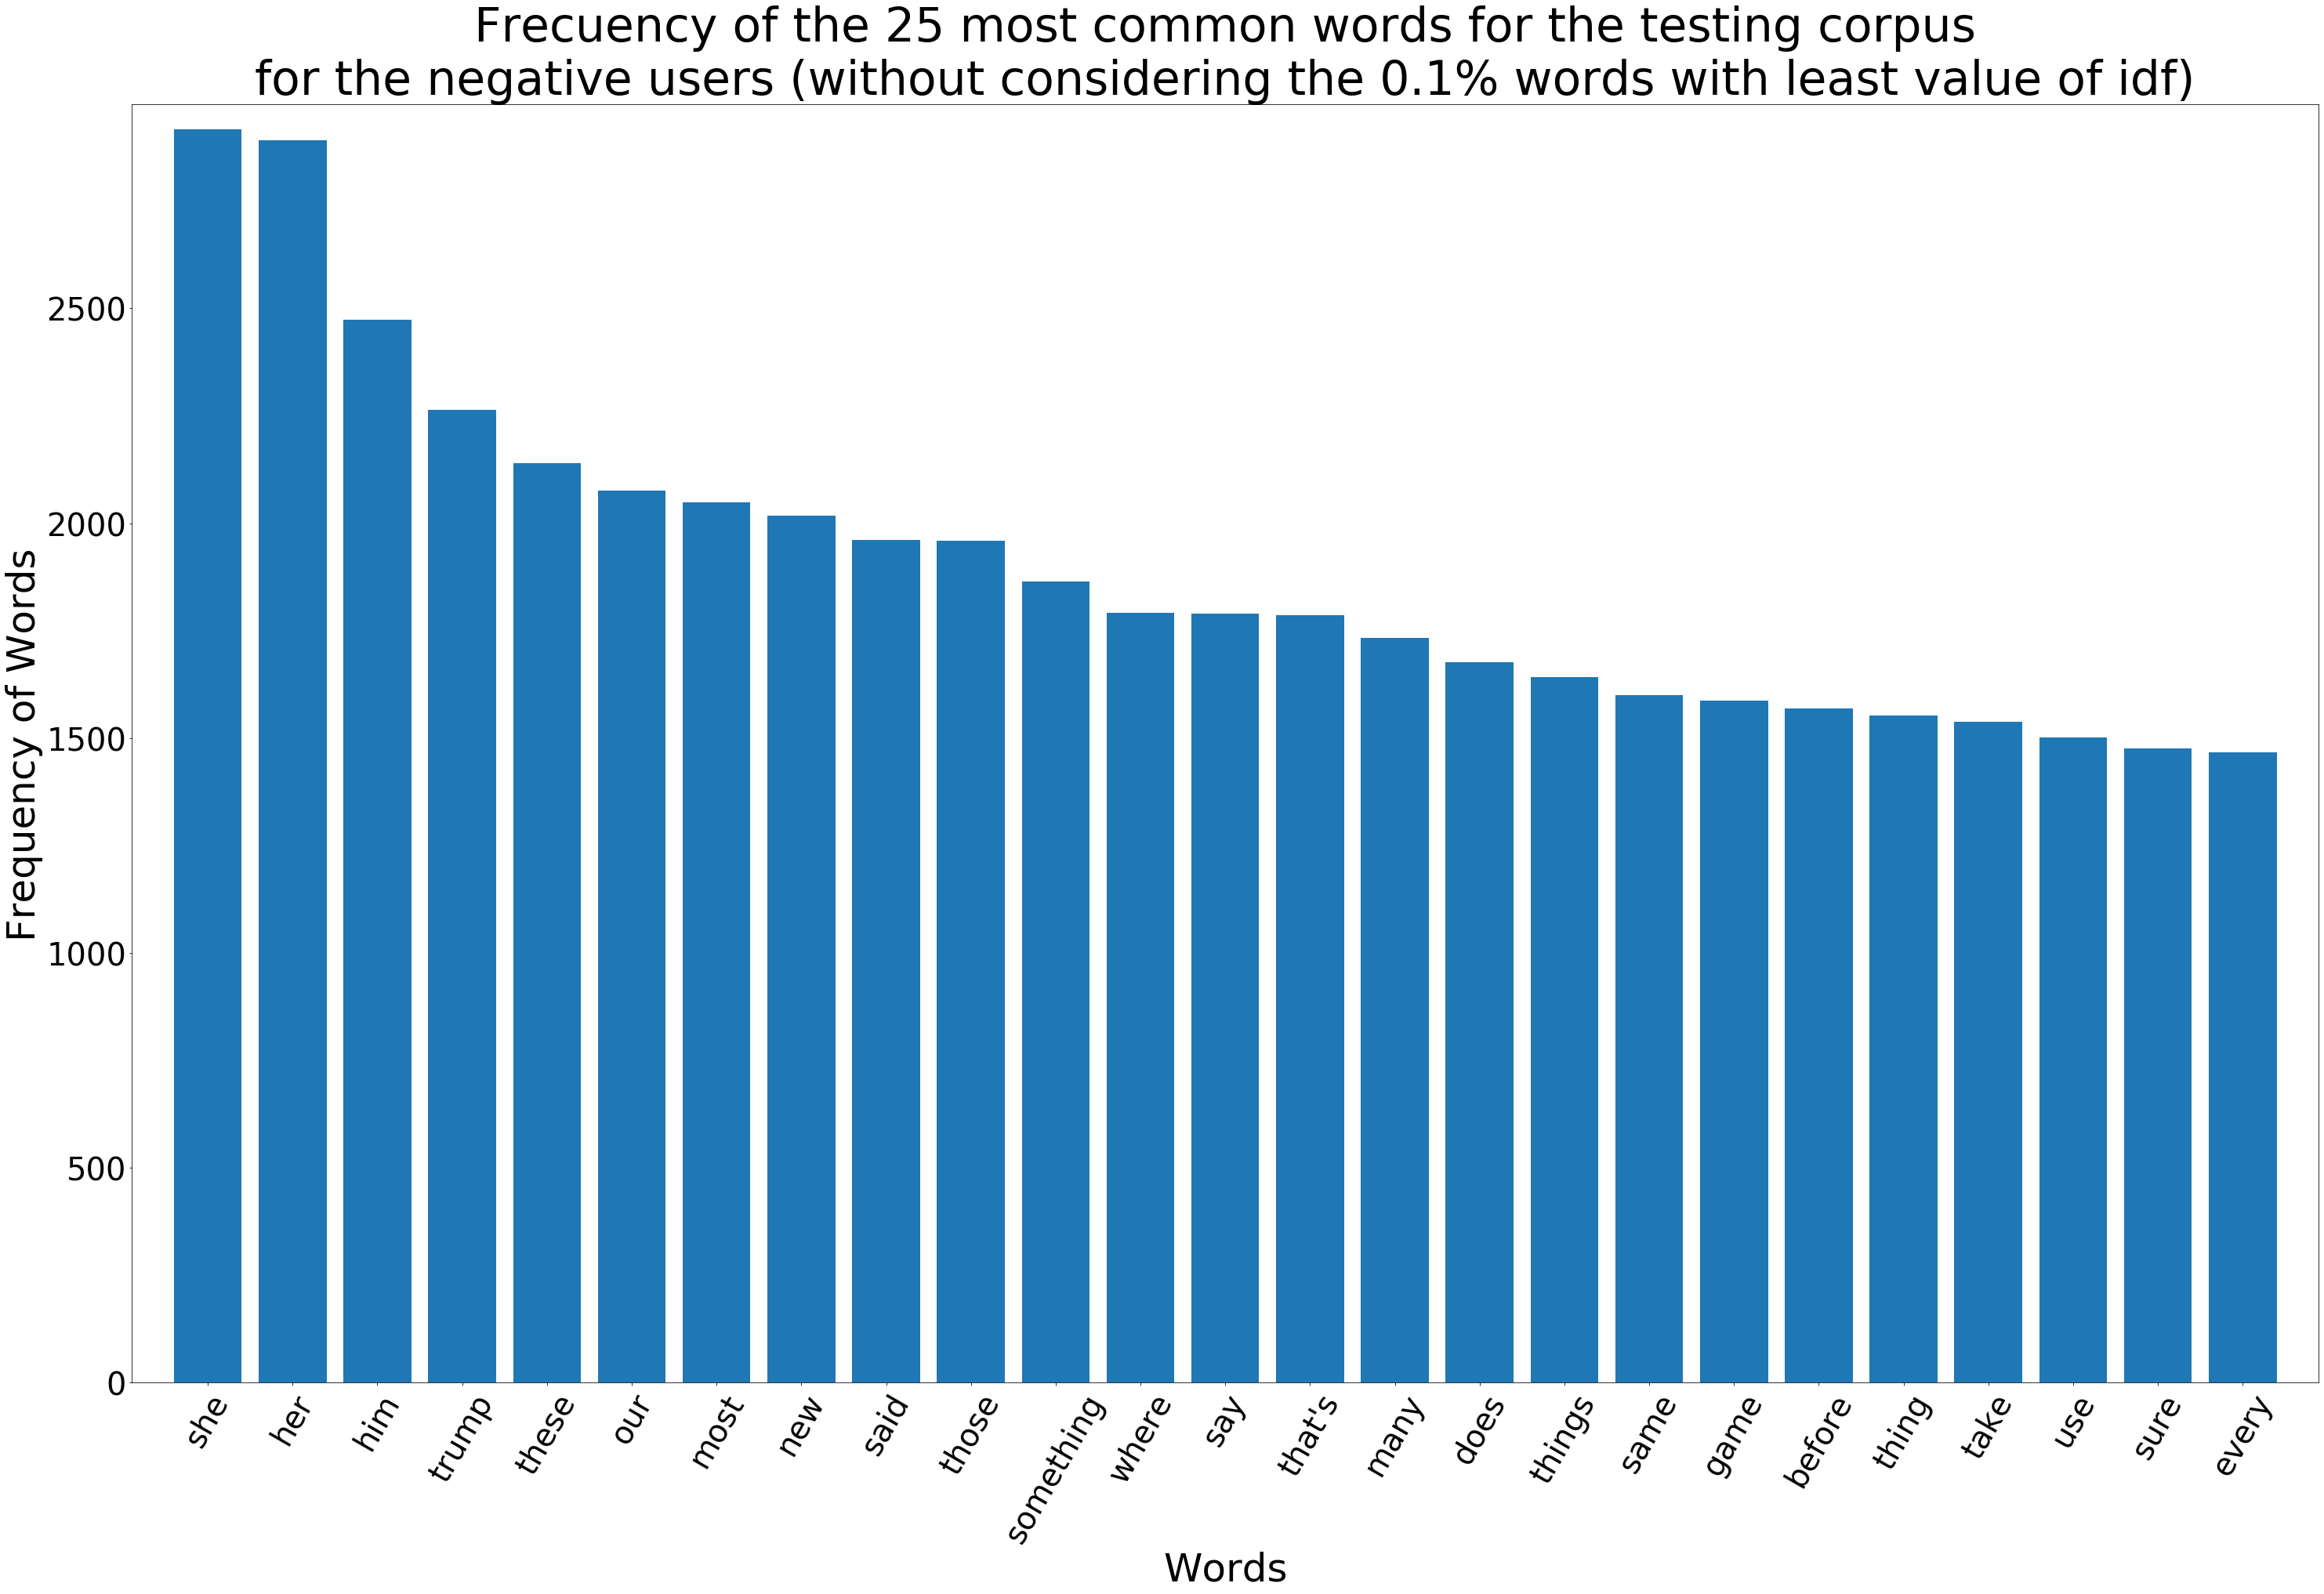

In [52]:
negative_mostcommon_small = FreqDist(result_negative_users_posts.split()).most_common(
    25
)

x, y = zip(*negative_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the testing corpus\nfor the negative users (without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=60,
)
plt.show()